In [ ]:
#%reset
# Set path for module imports
import sys
# replace the path below with the absolute path to your `scattering/` folder
pkg_root = "/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation" #"/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation"
sys.path.insert(0, pkg_root)

#%load_ext autoreload
#%autoreload 2

# Run this cell to import necessary libraries
import json
import yaml
import pickle
import logging
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['STIXGeneral', 'DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.unicode_minus'] = True

log = logging.getLogger(__name__)

# --- Imports for the new interactive framework ---
import plotly.graph_objects as go
from ipywidgets import Dropdown, IntRangeSlider, FloatSlider, Label, VBox, HBox, Output, Button, Textarea
from IPython.display import display

# --- Your Pipeline's Imports ---
# Make sure your scint_analysis package is importable
# (You may need to add its path using sys.path.insert)
#try:
from scint_analysis import config, pipeline, plotting
from scint_analysis.analysis import lorentzian_component, gaussian_component
from scint_analysis.core import ACF
from scint_analysis.config import update_fitting_parameter, update_pipeline_parameter, update_yaml_guesses
#except ImportError as e:
#    logging.error(f"Could not import scint_analysis. Make sure it's in your Python path. {e}")

# --- 1. Configuration ---
# Set up basic logging to see pipeline output in the notebook
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Define the path to the configuration file for the analysis run
BURST_CONFIG_PATH = '/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/configs/bursts/wilhelm_dsa.yaml' #'/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/wilhelm_dsa.yaml'
ACF_RESULTS_PATH = '/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/wilhelm/wilhelm_acf_results.pkl'
# Load the merged configuration from the YAML files
try:
    analysis_config = config.load_config(BURST_CONFIG_PATH)
    print("--- Loaded Configuration ---")
    print(json.dumps(analysis_config, indent=2))
except Exception as e:
    logging.error(f"Failed to load configuration: {e}")
    # Stop execution if config fails
    raise

# --- 2. Initialize the Pipeline Object ---
print("\n--- Initializing Scintillation Pipeline ---")
scint_pipeline = pipeline.ScintillationAnalysis(analysis_config)

print("\n--- Initializing and Running Scintillation Pipeline ---")
# Create an instance of the main pipeline controller
scint_pipeline = pipeline.ScintillationAnalysis(analysis_config)

# --- 3. Prepare Data for Interactive Use ---
# This new step loads the data and populates scint_pipeline.masked_spectrum
scint_pipeline.prepare_data()

# --- 4. Run the Interactive Window Selector ---
# ==============================================================================
# Interactive On/Off-Pulse Window Selector
# ==============================================================================
# This tool allows you to visually select the on-pulse and off-pulse windows
# and save them directly to the burst's YAML configuration file.

if 'scint_pipeline' not in locals() or scint_pipeline.masked_spectrum is None:
    print("Please run the initial pipeline setup cells first.")
else:
    # --- Helper function to update the YAML file ---
    def update_rfi_config(config_path, key, value_list):
        try:
            with open(config_path, 'r') as f:
                config_data = yaml.safe_load(f)
            rfi_section = config_data.setdefault('analysis', {}).setdefault('rfi_masking', {})
            rfi_section[key] = value_list
            with open(config_path, 'w') as f:
                yaml.dump(config_data, f, default_flow_style=False, sort_keys=False)
            return f"Success! Updated '{key}' to {value_list} in {config_path.split('/')[-1]}"
        except Exception as e:
            return f"Error updating YAML: {e}"

    # --- Main Interactive Function ---
    def interactive_window_selector(pipeline_obj, config_path):
        spectrum = pipeline_obj.masked_spectrum
        time_series = spectrum.get_profile()
        time_axis = spectrum.times
        max_bin = len(time_axis) - 1
        total_duration = time_axis[-1] - time_axis[0]
        
        # Find the center of the pulse to center the zoom
        peak_time_bin = np.argmax(time_series.filled(0))
        center_time = time_axis[peak_time_bin]

        # --- Create Widgets ---
        on_pulse_slider = IntRangeSlider(value=[max_bin // 2, 3 * max_bin // 4], min=0, max=max_bin, step=1, description='On-Pulse Bins:', style={'description_width': 'initial'}, layout={'width': '95%'})
        off_pulse_slider = IntRangeSlider(value=[0, max_bin // 4], min=0, max=max_bin, step=1, description='Off-Pulse Bins:', style={'description_width': 'initial'}, layout={'width': '95%'})
        
        # NEW: A slider to control the zoom *width* around the pulse center
        zoom_width_slider = FloatSlider(
            value=total_duration,
            min=total_duration * 0.01, # Min zoom is 1% of total duration
            max=total_duration,
            step=total_duration / 200,
            description='Zoom Width (s):',
            readout_format='.3f',
            style={'description_width': 'initial'},
            layout={'width': '95%'}
        )
        
        save_button = Button(description="Save Windows to YAML", button_style='primary', icon='save')
        status_label = Label(value="Adjust sliders to select regions.")
        plot_output = Output()

        # --- Plotting Function ---
        def draw_plot(on_pulse_range, off_pulse_range, zoom_width):
            with plot_output:
                plot_output.clear_output(wait=True)
                fig, ax = plt.subplots(figsize=(12, 5))
                
                # Calculate the zoom window centered on the peak
                zoom_min = center_time - (zoom_width / 2)
                zoom_max = center_time + (zoom_width / 2)
                
                ax.plot(time_axis, time_series, color='navy', label='Profile')
                ax.axvspan(time_axis[on_pulse_range[0]], time_axis[on_pulse_range[1]], color='cyan', alpha=0.4, label='On-Pulse')
                ax.axvspan(time_axis[off_pulse_range[0]], time_axis[off_pulse_range[1]], color='orange', alpha=0.4, label='Off-Pulse (Noise)')
                
                ax.set_title("On/Off-Pulse Window Selector")
                ax.set_xlabel("Time (s)"), ax.set_ylabel("Power")
                ax.grid(True, linestyle=':'), ax.legend()
                ax.set_xlim(zoom_min, zoom_max) # Apply the centered zoom
                plt.show()

        # --- Callbacks ---
        def on_change(change):
            draw_plot(on_pulse_slider.value, off_pulse_slider.value, zoom_width_slider.value)

        def on_save_clicked(b):
            on_pulse_window = list(on_pulse_slider.value)
            off_pulse_window = list(off_pulse_slider.value)
            msg1 = update_rfi_config(config_path, 'manual_burst_window', on_pulse_window)
            msg2 = update_rfi_config(config_path, 'manual_noise_window', off_pulse_window)
            status_label.value = f"{msg1} | {msg2}"
            pipeline_obj.config['analysis']['rfi_masking']['manual_burst_window'] = on_pulse_window
            pipeline_obj.config['analysis']['rfi_masking']['manual_noise_window'] = off_pulse_window

        # --- Link widgets and display ---
        on_pulse_slider.observe(on_change, names='value')
        off_pulse_slider.observe(on_change, names='value')
        zoom_width_slider.observe(on_change, names='value') # Connect the new slider
        save_button.on_click(on_save_clicked)
        
        dashboard = VBox([zoom_width_slider, on_pulse_slider, off_pulse_slider, plot_output, HBox([save_button, status_label])])
        display(dashboard)
        draw_plot(on_pulse_slider.value, off_pulse_slider.value, zoom_width_slider.value)

    # --- Run the interactive tool ---
    interactive_window_selector(scint_pipeline, BURST_CONFIG_PATH)


INFO: Loading burst configuration from: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/configs/bursts/wilhelm_dsa.yaml
INFO: Loading telescope configuration from: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/configs/bursts/../telescopes/dsa.yaml
INFO: Configurations successfully loaded and merged.
INFO: Intermediate results will be cached in: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/wilhelm/
INFO: Intermediate results will be cached in: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/wilhelm/
INFO: --- Preparing Data ---
INFO: Intermediate results will be cached in: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/wilhelm/
INFO: Loading and processing raw data...
INFO: Loading DynamicSpec

--- Loaded Configuration ---
{
  "telescope_name": "DSA-110",
  "instrument_type": "Multi-Dish Interferometer",
  "native_channel_width_mhz": 0.03051757812,
  "total_bandwidth_mhz": 187.5,
  "num_channels": 6144,
  "min_freq_mhz": 1311.25,
  "max_freq_mhz": 1498.75,
  "burst_id": "wilhelm",
  "input_data_path": "/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/wilhelm.npz",
  "telescope": "dsa",
  "analysis": {
    "rfi_masking": {
      "find_burst_thres": 8.0,
      "padding_factor": 0.0,
      "use_symmetric_noise_window": true,
      "rfi_downsample_factor": 16,
      "enable_time_domain_flagging": false,
      "time_threshold_sigma": 7.0,
      "freq_threshold_sigma": 5.0,
      "manual_burst_window": [
        1249,
        1268
      ],
      "manual_noise_window": [
        0,
        624
      ]
    },
    "acf": {
      "num_subbands": 1,
      "max_lag_mhz": 200.0,
      "use_snr_subbanding": true,
      "enable_intra_p

INFO: Spectrum shape: (6144, 2500)
INFO: Applying RFI masking.
INFO: Using time downsampling factor of 16 for RFI statistical checks.
INFO: RFI MASKING: Using manually specified on-pulse window: [1249, 1268]
INFO: Using symmetric noise window of duration 19 bins.
INFO: Using downsampled noise statistics from bins 76 to 78.


Manual window set to [1249, 1268]


Iterative RFI Masking in Frequency Domain:  20%|██        | 1/5 [00:00<00:00, 129.52it/s]
INFO: Masked 5 channels based on frequency-domain stats.
INFO: Skipping time-domain RFI flagging as per configuration.
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 2500)
INFO: --- Data Preparation Finished ---


INFO: Data already prepared. Skipping.
INFO: --- Starting Scintillation Pipeline for wilhelm ---
INFO: Applying polynomial baseline subtraction...
INFO: Performing order-1 polynomial baseline subtraction using off-pulse spectrum.
INFO: Baseline subtraction complete.
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 2500)
INFO: Generating diagnostic plots...
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 32)
INFO: Generating diagnostic plot: On-Pulse Region
INFO: Diagnostic plot saved to: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics/wilhelm_on_pulse_diagnostic.png


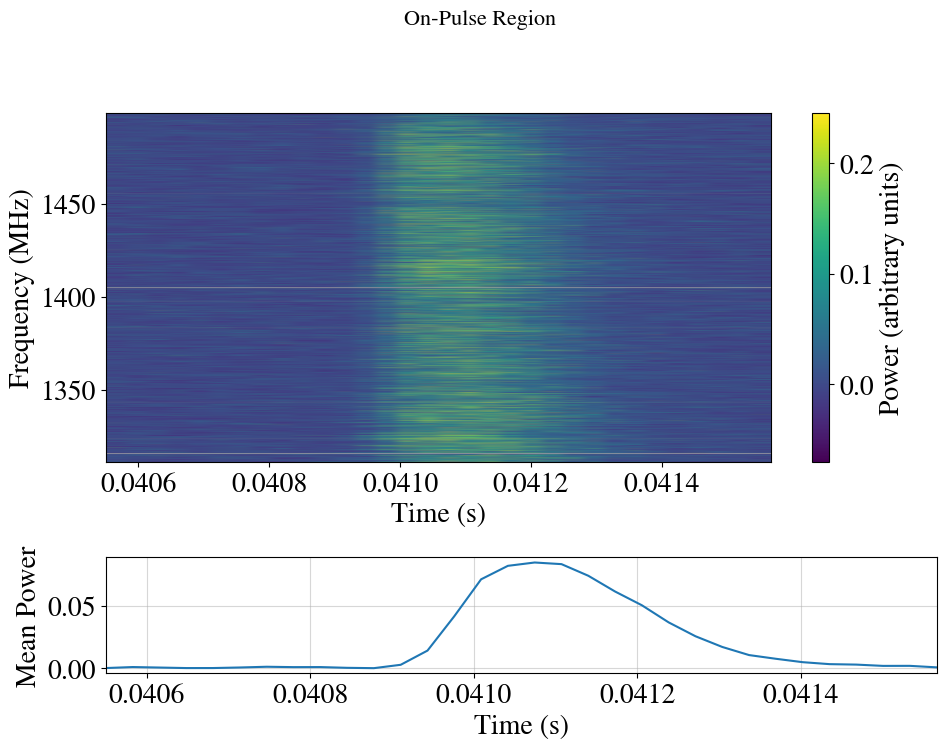

INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 1194)
INFO: Generating diagnostic plot: Off-Pulse (Noise) Region
INFO: Diagnostic plot saved to: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics/wilhelm_off_pulse_diagnostic.png


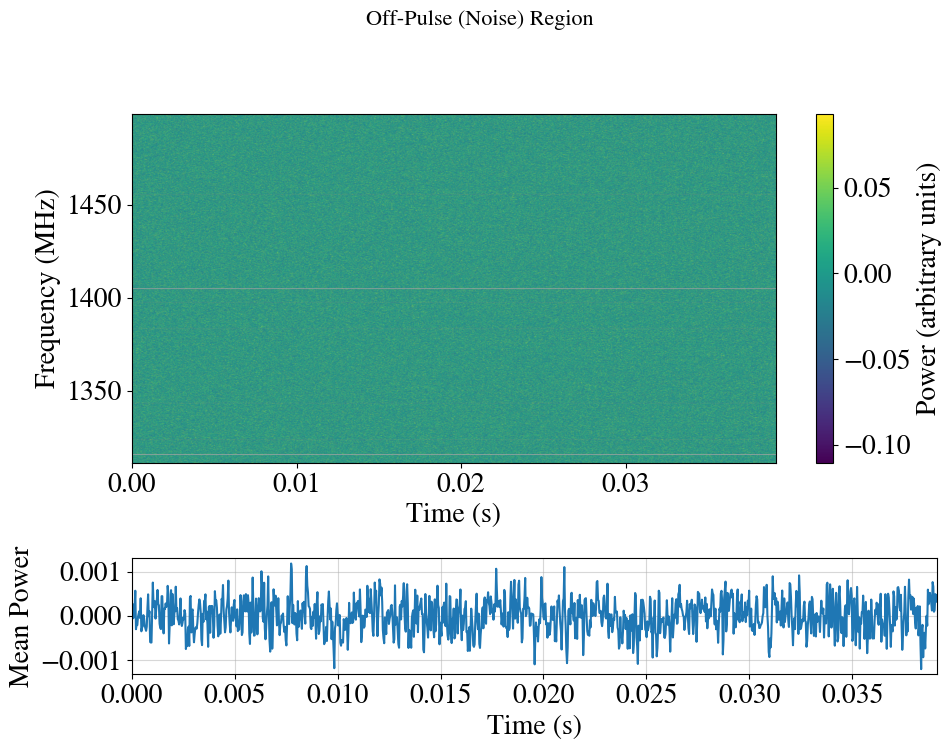

INFO: On/Off pulse diagnostic plots saved to: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics
INFO: Generating baseline fit diagnostic plot.
INFO: Generating baseline fit diagnostic plot.
INFO: Baseline diagnostic plot saved to: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics/wilhelm_baseline_diagnostic.png


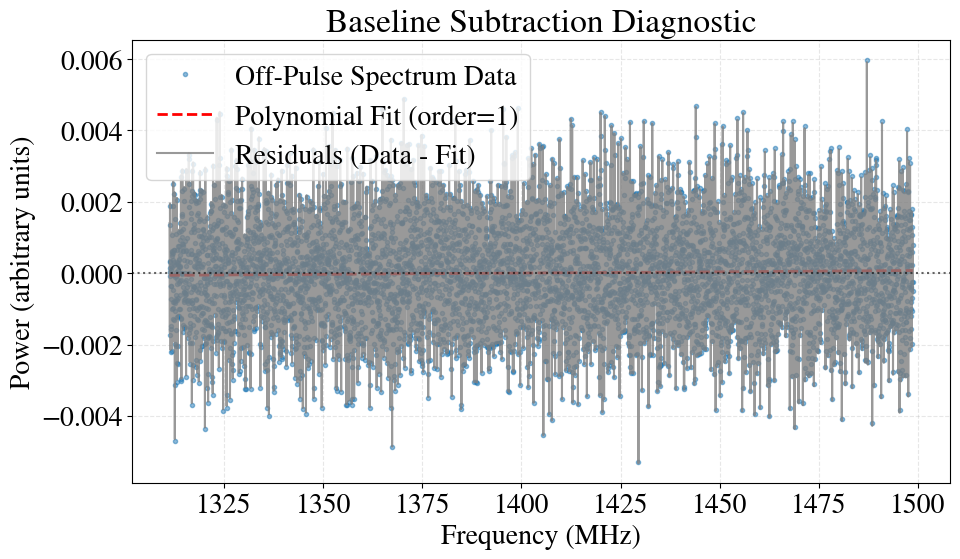

INFO: Characterizing off-pulse noise...
/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/scint_analysis/noise.py:145: UserWarning: NaNs detected – in‑painting with row/col medians.
  warnings.warn("NaNs detected – in‑painting with row/col medians.")
/Users/jakobfaber/.local/share/mamba/envs/chimedsa/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1216: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,
INFO: Noise characterization complete. Detected kind: 'flux_shiftedgamma'
INFO: Calculating ACFs for all sub-bands...
INFO: Starting sub‑band ACF calculations (self‑noise + synthetic‑noise aware).
ACF per sub‑band: 100%|██████████| 1/1 [00:28<00:00, 28.14s/it]
INFO: Saved ACF results to cache: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/wilhelm/wilhelm_acf_results.pkl
INFO: 'halt_after_acf' is set to True. H

--- Pipeline Execution Finished ---


In [2]:
# --- 4. Run the Pipeline ---
# This single .run() call executes all the steps in the correct order:
# - Loads and masks data
# - Characterizes off-pulse noise (NEW)
# - Calculates ACFs using the noise model for normalization
scint_pipeline.run()
print("--- Pipeline Execution Finished ---")

In [ ]:
# ==============================================================================
# Manual ACF Fitting Notebook – hierarchical 1–3-component fitter  ✨
# ------------------------------------------------------------------------------
# • Choose up to THREE single-component models (Lorentzian, Gaussian,
#   Generalised-Lorentzian, Power-law) and build a composite fit on-the-fly.
# • Hard lower limit on all γ / σ sliders and bounds: 0.1.
# • Live initial-guess preview, lag-range sync, stored-fits printer, YAML export.
# ==============================================================================

import pickle
import yaml
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
from lmfit.models import ConstantModel
from ipywidgets import (
    IntSlider, FloatSlider, FloatRangeSlider, FloatText,
    Dropdown, Checkbox, VBox, HBox, Button, Output, Textarea, Label
)
from IPython.display import display

# ──────────────────────────────────────────────────────────────────────────────
# 0.  Import single-component model functions (from your scint_analysis pkg)
# ──────────────────────────────────────────────────────────────────────────────
from scint_analysis.analysis import (
    _make_noise_model,
    calculate_acf,
    lorentzian_component,
    gaussian_component,
    lorentzian_generalised,
    power_law_model,
)

# ──────────────────────────────────────────────────────────────────────────────
# 1.  Load cached ACF data
# ──────────────────────────────────────────────────────────────────────────────
with open(ACF_RESULTS_PATH, "rb") as f:
    acf_results = pickle.load(f)

num_subbands = len(acf_results["subband_acfs"])
print(f"Loaded ACFs for {num_subbands} sub-bands.")

# ──────────────────────────────────────────────────────────────────────────────
# 2.  Library of single-component models
# ──────────────────────────────────────────────────────────────────────────────
MODEL_CONFIG = {
    "Lorentzian": {
        "func": lorentzian_component,
        "prefix": "l_",
        "param_names": ["gamma", "m"],
    },
    "Gaussian": {
        "func": gaussian_component,
        "prefix": "g_",
        "param_names": ["sigma", "m"],
    },
    "Gen-Lorentz": {
        "func": lorentzian_generalised,
        "prefix": "lg_",
        "param_names": ["gamma", "alpha", "m"],
    },
    "Power-Law": {
        "func": power_law_model,
        "prefix": "p_",
        "param_names": ["c", "n"],
        },
    }

# ──────────────────────────────────────────────────────────────────────────────
# 3.  Widgets
# ──────────────────────────────────────────────────────────────────────────────
subband_slider = IntSlider(0, 0, num_subbands - 1, 1, description="Sub-band:")

prim_dd  = Dropdown(options=list(MODEL_CONFIG.keys()), value="Lorentzian", description="Model 1:")
add2_cb  = Checkbox(False, description="+2nd")
sec_dd   = Dropdown(options=list(MODEL_CONFIG.keys()), value="Gaussian",   description="Model 2:", disabled=True)
add3_cb  = Checkbox(False, description="+3rd")
thr_dd   = Dropdown(options=list(MODEL_CONFIG.keys()), value="Power-Law", description="Model 3:", disabled=True)

# enable / disable extra dropdowns
add2_cb.observe(lambda ch: setattr(sec_dd, "disabled", not ch["new"]), names="value")
add3_cb.observe(lambda ch: setattr(thr_dd, "disabled", not ch["new"]), names="value")

# lag-range widgets
max_lag = float(max(np.max(np.abs(l)) for l in acf_results["subband_lags_mhz"]))
fit_min_txt = FloatText(-max_lag, description="Min Lag:")
fit_max_txt = FloatText( max_lag, description="Max Lag:")
fit_rng_slider = FloatRangeSlider(value=(-max_lag, max_lag), min=-max_lag, max=max_lag,
                                  step=0.1, description="Fit Range Slider:")

ignore_err_cb = Checkbox(False, description="Ignore σ")

fit_btn   = Button(description="Perform Fit", button_style="success", icon="cogs")
print_btn = Button(description="Print Fits",  button_style="info",    icon="print")
save_btn  = Button(description="Save→YAML",   button_style="warning", icon="save")
plot_noise_btn = Button(description="Plot Noise Synthesis", button_style="info", icon="chart-area")


param_box  = VBox([])
plot_out   = Output()
results_tb = Textarea(layout={"width": "98%", "height": "200px"})
status_lbl = Label()
stats_lbl  = Label("Fit Stats: N/A")

# ──────────────────────────────────────────────────────────────────────────────
# 4.  Parameter-widget factory
# ──────────────────────────────────────────────────────────────────────────────
LOWER_WIDTH = 0.06  # hard floor for gamma / sigma

def _slider(desc, kind, val=0.5):
    if kind == "width":
        return FloatSlider(value=max(val, LOWER_WIDTH), min=LOWER_WIDTH, max=15,
                           step=0.01, description=desc)
    if kind == "m":
        return FloatSlider(value=val, min=0, max=4, step=0.01, description=desc)
    if kind == "c":
        return FloatSlider(value=0.0, min=0., max=0.5, step=0.001,
                           description=desc)
    if kind == "alpha":
        return FloatText(value=5/3, description=desc)
    if kind == "n":
        return FloatSlider(value=-2, min=-6, max=-1, step=0.1,
                           description=desc)
    return FloatText(value=val, description=desc)

def _make_widgets(model_key: str, idx: int):
    """Create ipywidgets for one component and hook them to live-preview."""
    cfg     = MODEL_CONFIG[model_key]
    prefix  = f"{cfg['prefix']}{idx}_"
    names   = cfg["param_names"]
    widgets = []

    i = 0
    while i < len(names):
        nm = names[i]

        # ---------- width sliders (gamma / sigma) ----------
        if nm.startswith(("gamma", "sigma")):
            w_width = _slider(prefix + nm, "width")
            w_width.observe(_on_visual_change, names="value")

            row = [w_width]

            # optional companion m-slider
            if i + 1 < len(names) and names[i + 1].startswith("m"):
                w_m = _slider(prefix + names[i + 1], "m")
                w_m.observe(_on_visual_change, names="value")
                row.append(w_m)
                i += 1                   # skip companion name

            widgets.append(HBox(row))

        # ---------- alpha ----------------------------------
        elif nm == "alpha":
            w_alpha = _slider(prefix + nm, "alpha")
            w_alpha.observe(_on_visual_change, names="value")
            widgets.append(w_alpha)

        # ---------- modulation index m ----------------------
        elif nm.startswith("m"):
            w_m = _slider(prefix + nm, "m")
            w_m.observe(_on_visual_change, names="value")
            widgets.append(w_m)

        # This original 'c' check can be removed or kept for other models
        elif nm == "c":  
            w_c = _slider(prefix + nm, "c")
            w_c.observe(_on_visual_change, names="value")
            widgets.append(w_c)

        elif nm == "n":
            w_n = _slider(prefix + nm, "n")
            w_n.observe(_on_visual_change, names="value")
            widgets.append(w_n)

        i += 1

    return widgets

def _refresh_param_box(*_):
    children = _make_widgets(prim_dd.value, 1)
    if add2_cb.value:
        children += _make_widgets(sec_dd.value, 2)
    if add3_cb.value:
        children += _make_widgets(thr_dd.value, 3)
    param_box.children = tuple(children)
    _draw_plot(initial_only=True)

for w in (prim_dd, sec_dd, thr_dd, add2_cb, add3_cb):
    w.observe(_refresh_param_box, names="value")

# ──────────────────────────────────────────────────────────────────────────────
# 5.  Helpers
# ──────────────────────────────────────────────────────────────────────────────
def _param_vals():
    vals = []
    for child in param_box.children:
        vals += [wid.value for wid in (child.children if isinstance(child, HBox) else (child,))]
    return vals

def _auto_bounds(params):
    for name, par in params.items():
        if any(key in name for key in ("gamma", "sigma")):
            par.set(min=LOWER_WIDTH)
        elif name.endswith("m") or name.endswith("_m"):
            par.set(min=0)
        elif "alpha" in name:
            par.set(min=0.1, max=6)

# ──────────────────────────────────────────────────────────────────────────────
# 6.  Plot helper (initial guess & best fit)
# ──────────────────────────────────────────────────────────────────────────────

def plot_noise_template_synthesis(subband_index):
    """
    Generates and plots the individual noise ACFs and their average.
    """
    noise_desc = scint_pipeline.noise_descriptor
    if not noise_desc:
        print("Noise descriptor not found. Please enable noise analysis.")
        return

    # Get config parameters
    n_rep = analysis_config.get('analysis', {}).get('noise', {}).get('template_n_draws', 25)
    max_lag_mhz = analysis_config.get('analysis', {}).get('acf', {}).get('max_lag_mhz', 45.0)
    
    # Get sub-band specific parameters
    sub_spec = scint_pipeline.masked_spectrum.power[subband_index, :] # Use one channel as representative
    chan_width = scint_pipeline.masked_spectrum.channel_width_mhz
    max_lag_bins_sub = int(max_lag_mhz / chan_width)

    # Generate and store the ACFs
    all_noise_acfs = []
    for _ in range(n_rep):
        noise_row = noise_desc.sample()[0]
        acf_obj = calculate_acf(
            np.ma.masked_invalid(noise_row),
            chan_width,
            off_burst_spectrum_mean=0.0,
            max_lag_bins=max_lag_bins_sub
        )
        if acf_obj:
            all_noise_acfs.append(acf_obj.acf)

    if not all_noise_acfs:
        print("Failed to generate any noise ACFs.")
        return

    all_noise_acfs = np.array(all_noise_acfs)
    mean_template = np.mean(all_noise_acfs, axis=0)
    lags = acf_obj.lags # Lags from the last generated ACF

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    for noise_acf in all_noise_acfs:
        ax.plot(lags, noise_acf, color='gray', alpha=0.2)
    
    ax.plot(lags, mean_template, color='deepskyblue', lw=2.5, label=f'Mean Template (from {n_rep} draws)')
    ax.set_title(f"Noise Template Synthesis for Sub-band {subband_index}")
    ax.set_xlabel("Frequency Lag (MHz)")
    ax.set_ylabel("Autocorrelation")
    ax.legend()
    ax.grid(True, linestyle=':')
    plt.show()

def _draw_plot(initial_only=False, fit_res=None):
    sb = subband_slider.value
    lags = acf_results["subband_lags_mhz"][sb]
    acf  = acf_results["subband_acfs"][sb]
    errs = acf_results.get("subband_acfs_err", [None] * num_subbands)[sb]

    m0, m1 = fit_rng_slider.value
    mask = (lags >= m0) & (lags <= m1) & (lags != 0)
    x_fit, y_fit = lags[mask], acf[mask]

    with plot_out:
        plot_out.clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(12, 6)) # Increased figure size for clarity
        ax.errorbar(lags, acf, yerr=None if errs is None or ignore_err_cb.value else errs,
                    fmt=".", ms=3, capsize=3, color="lightgray", label="All data", zorder=1)
        ax.plot(x_fit, y_fit, '-', ms=4, color="purple", alpha=0.6, label="Fit range", zorder=2)

        # initial-guess curve
        if initial_only and x_fit.size:
            vals, idx, guess = _param_vals(), 0, np.zeros_like(x_fit)
            sequence = [prim_dd.value] \
                     + ([sec_dd.value]  if add2_cb.value else []) \
                     + ([thr_dd.value]  if add3_cb.value else [])
            for key in sequence:
                # build initial-guess curve component-by-component
                cfg  = MODEL_CONFIG[key]
                npar = len(cfg["param_names"])          # ← define npar here
                guess += cfg["func"](x_fit, *vals[idx: idx + npar])
                idx   += npar                           # advance pointer

            ax.plot(x_fit, guess, c="pink", label="Initial guess", zorder=3)

        if fit_res is not None:
            # Plot the total composite fit (the sum of all components)
            ax.plot(x_fit, fit_res.best_fit, "k-", lw=2.5, label="Best Composite Fit", zorder=10)

            # Plot individual components 
            components = fit_res.eval_components(x=x_fit)
            for prefix, component_curve in components.items():
                # Use different line styles and colors for clarity
                if 'tpl' in prefix:
                    style = {'color': 'm', 'linestyle': '--', 'lw': 2, 'label': 'Noise Template Fit'}
                    ax.plot(x_fit, component_curve, **style, zorder=5)
                #elif 'l' in prefix or 'g' in prefix: # Primary signal component
                #    style = {'color': 'red', 'linestyle': ':', 'lw': 2, 'label': f'Signal Component {prefix.strip("_")}'}
                #else: # Other signal components
                #    style = {'color': 'orange', 'linestyle': ':', 'lw': 2, 'label': f"Signal Comp. ({prefix.strip('_')})"}
                #ax.plot(x_fit, component_curve, **style, zorder=5)

        # This part for axes and labels remains the same...
        idx0, idx1 = np.abs(lags - m0).argmin(), np.abs(lags - m1).argmin()
        ax.set_ylim(np.min(y_fit) - 0.05, np.max(y_fit) + 0.05)
        ax.set_xlim(m0 - (0.05 * (m1-m0)), m1 + (0.05 * (m1-m0))) # Add 5% padding
        ax.set_xlabel("Δν (MHz)")
        ax.set_ylabel("C_I")
        ax.grid(ls=":")
        ax.legend(loc="upper right")
        plt.show()

def _on_visual_change(change=None):
    """Redraw the initial-guess preview whenever a GUI control moves."""
    _draw_plot(initial_only=True)

# ---------------------------------------------------------------------------
# 7.  Lag-range textbox ⇆ slider synchronisation
# ---------------------------------------------------------------------------
def _sync_text_to_slider(_):
    if fit_min_txt.value < fit_max_txt.value:
        fit_rng_slider.value = (fit_min_txt.value, fit_max_txt.value)

def _sync_slider_to_text(ch):
    fit_min_txt.value, fit_max_txt.value = (round(ch["new"][0], 2),
                                            round(ch["new"][1], 2))

fit_min_txt.observe(_sync_text_to_slider, names="value")
fit_max_txt.observe(_sync_text_to_slider, names="value")
fit_rng_slider.observe(_sync_slider_to_text, names="value")

fit_rng_slider.observe(_on_visual_change, names="value")
fit_min_txt.observe(_on_visual_change, names="value")
fit_max_txt.observe(_on_visual_change, names="value")

subband_slider.observe(_on_visual_change, names="value")
# ---------------------------------------------------------------------------
# 8.  Fit callback
# ---------------------------------------------------------------------------
all_fits = {}

def _on_fit(_):
    sb = subband_slider.value
    lags = acf_results["subband_lags_mhz"][sb]
    acf  = acf_results["subband_acfs"][sb]
    errs = acf_results.get("subband_acfs_err", [None] * num_subbands)[sb]
    m0, m1 = fit_rng_slider.value
    mask = (lags >= m0) & (lags <= m1) & (lags != 0)
    x, y = lags[mask], acf[mask]
    wts = None if (ignore_err_cb.value or errs is None) else 1.0 / np.maximum(errs[mask], 1e-9)
    comps = [prim_dd.value] + ([sec_dd.value] if add2_cb.value else []) + ([thr_dd.value] if add3_cb.value else [])
    
    # Build the signal part of the model from GUI selections
    signal_model, params = None, None
    vals, idx = _param_vals(), 0
    for i, key in enumerate(comps, start=1):
        cfg = MODEL_CONFIG[key]
        m = Model(cfg["func"], prefix=f"{cfg['prefix']}{i}_")
        p = m.make_params()
        n = len(cfg["param_names"])
        for val, pname in zip(vals[idx : idx + n], p.keys()):
            p[pname].set(value=val)
        idx += n
        _auto_bounds(p)
        signal_model, params = (m, p) if signal_model is None else (signal_model + m, params.update(p) or signal_model)

    # Now, add a single, shared constant model for the baseline
    if signal_model is not None:
        log.info('Signal Model is not None, adding ConstantModel...')
        const_model = ConstantModel(prefix='c_')
        params.update(const_model.make_params(c=0.0)) # Add the constant parameter
        composite_model = signal_model + const_model
    else:
        # Handle case where no signal model was selected
        log.info('Signal Model is None, using only ConstantModel...')
        composite_model = ConstantModel(prefix='c_')
        params = composite_model.make_params(c=0.0)

    # Perform the fit
    result = composite_model.fit(y, params, x=x, weights=wts)
    all_fits[(sb, tuple(comps))] = result

    # Update GUI with results (this part is unchanged)
    mean_sigma = np.nan if wts is None else float(1 / np.mean(wts))
    stats_lbl.value = f"χ²ᵣ = {result.redchi:.3f}   |   BIC = {result.bic:.2f}   |   ⟨σ⟩ = {mean_sigma:.4f}"
    _draw_plot(fit_res=result)

# ---------------------------------------------------------------------------
# 9.  Print & YAML callbacks
# ---------------------------------------------------------------------------
def _on_print(_):
    out = []
    for (sb, comps), res in all_fits.items():
        cf = acf_results["subband_center_freqs_mhz"][sb]
        out.append(f"--- Sub-band {sb} @ {cf:.2f} MHz :: {' + '.join(comps)}")
        for n, p in res.params.items():
            serr = p.stderr if p.stderr is not None else 0
            out.append(f"  {n}: {p.value:.4g} ± {serr:.2g}")
        out.append("")
    results_tb.value = "\n".join(out) if out else "No fits yet."

def _on_save(_):
    sb = subband_slider.value
    comps = [prim_dd.value] + ([sec_dd.value] if add2_cb.value else []) + ([thr_dd.value] if add3_cb.value else [])
    key  = (sb, tuple(comps))

    if key not in all_fits:
        status_lbl.value = "Run a fit first."
        return
        
    res = all_fits[key]
    tag = "+".join(comps)

    fit_range_mhz = list(fit_rng_slider.value)

    # --- START: MODIFIED SECTION TO SAVE ERRORS ---
    params_to_save = {}
    for name, param in res.params.items():
        # lmfit stderr can be None if not calculated, so handle that case
        error_value = float(param.stderr) if param.stderr is not None else 0.0
        params_to_save[name] = {'value': float(param.value), 'stderr': error_value}
    # --- END: MODIFIED SECTION ---

    entry = {
        "reference_frequency_mhz": float(acf_results["subband_center_freqs_mhz"][sb]),
        "best_fit_params": params_to_save, # Use the new dictionary with errors
        "redchi": float(res.redchi),
        "bic": float(res.bic),
        "fit_range_mhz": fit_range_mhz,
    }

    # The rest of the function remains the same...
    cfg = yaml.safe_load(open(BURST_CONFIG_PATH)) or {}
    cfg.setdefault("analysis", {}).setdefault("stored_fits", {}).setdefault(f"subband_{sb}", {})[tag] = entry
    yaml.safe_dump(cfg, open(BURST_CONFIG_PATH, "w"), sort_keys=False)
    status_lbl.value = f"Saved under subband_{sb} :: {tag}"

def _on_plot_noise_clicked(b):
    plot_noise_template_synthesis(subband_slider.value)

# ---------------------------------------------------------------------------
# 10.  Wire callbacks & build dashboard
# ---------------------------------------------------------------------------
fit_btn.on_click(_on_fit)
print_btn.on_click(_on_print)
save_btn.on_click(_on_save)

plot_noise_btn.on_click(_on_plot_noise_clicked)

fit_range_box = VBox([
    Label("Fit Lag Range (MHz):"),
    HBox([fit_min_txt, fit_max_txt]),
    fit_rng_slider,
])

dashboard = VBox([
    HBox([subband_slider, prim_dd, add2_cb, sec_dd, add3_cb, thr_dd]),
    fit_range_box,
    Label(r"Component Parameters $\gamma$, $\sigma$, $m$, $\alpha$, $n$"),
    param_box,
    HBox([fit_btn, print_btn, save_btn, plot_noise_btn]),
    status_lbl,
    stats_lbl,
    plot_out,
    results_tb,
])

display(dashboard)
_refresh_param_box()  # populate sliders & preview



Loaded ACFs for 1 sub-bands.


In [9]:
# In scint_analysis/plotting.py

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# In Cell 3 of your notebook, update this function

def format_value_with_error(value, error):
    """
    Formats a value and its error into the compact X(err) notation.
    e.g., 17.3 ± 1.5 becomes "17.3(15)"
    e.g., 0.3346 ± 0.0429 becomes "0.335(43)"
    """
    if error is None or not np.isfinite(error) or error <= 0:
        return f"{value:.3f}"

    # Determine the number of decimal places to round to, based on the error's magnitude
    # We aim for two significant figures in the error
    decimals = -int(np.floor(np.log10(error))) + 1
    decimals = max(0, decimals)
    
    # Format the value with the determined number of decimals
    value_str = f"{value:.{decimals}f}"
    
    # Format the error as an integer of the last digits
    error_int = int(round(error * (10**decimals)))
    
    return f"{value_str}({error_int})"

def load_fit_from_yaml(config_path, subband_index, model_name, lags):
    """
    Loads a saved fit from the YAML config, rebuilds the model, 
    and returns the evaluated curves and parameters for plotting.
    """
    with open(config_path, 'r') as f:
        config_data = yaml.safe_load(f)

    try:
        fit_data = config_data['analysis']['stored_fits'][f'subband_{subband_index}'][model_name]
        saved_params = fit_data['best_fit_params']
        redchi = fit_data['redchi']
        # --- NEW: Get the saved fit range ---
        fit_range = fit_data.get('fit_range_mhz') # .get() is safer
    except KeyError:
        print(f"Error: Could not find saved fit for sub-band {subband_index} with model '{model_name}'")
        return None

    # Rebuild the lmfit model (this logic is unchanged)
    component_keys = model_name.split('+')
    signal_model, params = None, None
    for i, key in enumerate(component_keys, start=1):
        if key in MODEL_CONFIG:
            cfg = MODEL_CONFIG[key]
            m = Model(cfg["func"], prefix=f"{cfg['prefix']}{i}_")
            if signal_model is None:
                signal_model = m
            else:
                signal_model += m
    
    const_model = ConstantModel(prefix='c_')
    composite_model = signal_model + const_model
    params = composite_model.make_params()

    # Set the parameter values from the loaded dictionary
    for param_name, param_info in saved_params.items():
        if param_name in params:
            # Get just the 'value' from the sub-dictionary
            params[param_name].set(value=param_info['value']) 

    # Evaluate curves
    best_fit_curve = composite_model.eval(params=params, x=lags)
    component_curves = composite_model.eval_components(params=params, x=lags)
    
    # --- NEW: Return the parameters dictionary as well ---
    return {
        "best_fit_curve": best_fit_curve,
        "component_curves": component_curves,
        "redchi": redchi,
        "params": saved_params,
        "fit_range_mhz": fit_range
    }

# In scint_analysis/plotting.py

# In scint_analysis/plotting.py

def plot_publication_acf(
    acf_obj: ACF,
    best_fit_curve: np.ndarray,
    component_curves: dict,
    redchi: float,
    params: dict,
    fit_range_mhz: list,
    zoom_lag_range_mhz=(-25, 25),
    save_path=None
):
    """
    Generates a publication-quality, 3-panel plot from pre-evaluated fit curves.
    """
    # Calculate residuals from the provided best_fit_curve argument
    plot_mask = (acf_obj.lags != 0)
    residuals = acf_obj.acf - best_fit_curve
    full_lag_range_mhz=(acf_obj.lags.min(), acf_obj.lags.max())

    # --- START: NEW SECTION TO GENERATE DYNAMIC LABEL ---
    # Auto-generate a descriptive legend label for the composite fit
    shape_component_keys = sorted([k for k in component_curves if 'c_' not in k])
    label_parts = []
    # Map model prefixes to their mathematical symbols
    model_map = {'l_': 'L', 'g_': 'G', 'lg_': 'L_{gen}', 'p_': 'P'}

    for prefix in shape_component_keys:
        # e.g., prefix is 'l_1_'
        base_prefix = prefix.split('_')[0] + '_'  # e.g., 'l_'
        index = prefix.split('_')[1]              # e.g., '1'
        symbol = model_map.get(base_prefix, '?')  # e.g., 'L'
        label_parts.append(f"$\mathcal{{{symbol}}}_{{{index}}}$")

    if 'c_' in component_curves:
        label_parts.append("$c$")

    composite_label = "Fit: " + " + ".join(label_parts)

    fig, (ax_a, ax_b, ax_c) = plt.subplots(
        3, 1,
        figsize=(10, 8),
        sharex=False,
        gridspec_kw={'height_ratios': [2, 3, 1.5]},
        constrained_layout=True
    )
    
    #cmap = cm.get_cmap('plasma', 4)
    colors = plt.get_cmap('plasma')(np.linspace(0.25, 0.75, 6))

    # --- Panel a: Wide View ---
    if acf_obj.err is not None:
        ax_a.errorbar(acf_obj.lags[plot_mask], acf_obj.acf[plot_mask], yerr=acf_obj.err[plot_mask], fmt='none', capsize=2, ecolor='lightgrey', alpha=1)
    ax_a.plot(acf_obj.lags[plot_mask], acf_obj.acf[plot_mask], color=colors[0], alpha=0.6, lw=1)
    ax_a.plot(acf_obj.lags, best_fit_curve, 'k-', lw=1.5, label=composite_label)
    ax_a.axvspan(zoom_lag_range_mhz[0], zoom_lag_range_mhz[1], color=colors[1], alpha=0.3, hatch='//', zorder=-1, label='Zoom In ($\mathbf{b}$)')
    #ax_a.set_xlim(full_lag_range_mhz)
    ax_a.set_xlim(acf_obj.lags.min(), acf_obj.lags.max())
    ax_a.set_ylim(np.min(acf_obj.acf[plot_mask])/2, np.max(acf_obj.acf[plot_mask])/2)
    ax_a.set_ylabel("ACF$~$ Power")
    #ax_a.grid(True, linestyle=':', alpha=0.6)
    ax_a.legend(loc = 'upper right',frameon=True,          # draw the legend patch
    fancybox=True,         # use a FancyBboxPatch (i.e. rounded corners)
    framealpha=0.8,        # overall opacity of the legend background
    facecolor='white',     # background color
    edgecolor='black',     # border color
    borderpad=0.3,
    fontsize='small')
    ax_a.text(0.02, 0.9, "a", transform=ax_a.transAxes, fontsize=20, fontweight='bold', va='top')

    # Set ylim for Panel A
    mask_a_zoom = (acf_obj.lags >= full_lag_range_mhz[0]) & (acf_obj.lags <= full_lag_range_mhz[1])
    if np.any(mask_a_zoom):
        min_val_a = np.min(acf_obj.acf[mask_a_zoom])/4
        max_val_a = np.max(acf_obj.acf[mask_a_zoom])/4
        padding_a = (max_val_a - min_val_a) * 0.1
        ax_a.set_ylim(min_val_a - padding_a, max_val_a + padding_a)

    # --- Panel b: Zoomed-in View ---
    if acf_obj.err is not None:
        ax_b.errorbar(acf_obj.lags[plot_mask], acf_obj.acf[plot_mask], yerr=acf_obj.err[plot_mask], fmt='none', capsize=2, ecolor='lightgrey', alpha=1)
    ax_b.plot(acf_obj.lags[plot_mask], acf_obj.acf[plot_mask], color=colors[2], alpha=0.6, lw=1)
    ax_b.plot(acf_obj.lags, best_fit_curve, 'k-', lw=2, label=composite_label)

    shape_component_keys = sorted([k for k in component_curves if 'c_' not in k])
    num_components = len(shape_component_keys)

    print("--- Fitted Decorrelation Bandwidths ---")
    for i, prefix in enumerate(shape_component_keys):
        color = colors[i]
        
        width_param_name = None
        for pname in params:
            if pname.startswith(prefix) and ('gamma' in pname or 'sigma' in pname):
                width_param_name = pname
                break
        
        if width_param_name and width_param_name in params:
            param_info = params[width_param_name]
            gamma_val, gamma_err = param_info['value'], param_info['stderr']

            gamma_val_khz = gamma_val * 1000
            gamma_err_khz = gamma_err * 1000 if gamma_err is not None else 0.0
            label_text = f"$\gamma_{i+1}$ = {format_value_with_error(gamma_val_khz, gamma_err_khz)} kHz"
            ax_b.plot(acf_obj.lags, component_curves[prefix], color=color, lw=2.0, linestyle='--', label=label_text)
    
    ax_b.axvspan(fit_range_mhz[0], fit_range_mhz[1], color=colors[3], alpha=0.3, hatch='//', zorder=-1, label='$\chi^2_r$ Fit Range')
    ax_b.set_xlim(fit_range_mhz[0]-5, fit_range_mhz[1]+5)
    ax_b.set_ylabel("ACF$~$ Power")
    ax_b.legend(loc='upper right', frameon=True,          # draw the legend patch
    fancybox=True,         # use a FancyBboxPatch (i.e. rounded corners)
    framealpha=0.8,        # overall opacity of the legend background
    facecolor='white',     # background color
    edgecolor='black',     # border color
    borderpad=0.3,
    fontsize='small')
    #ax_b.grid(True, linestyle=':', alpha=0.6)
    ax_b.text(0.02, 0.95, "b", transform=ax_b.transAxes, fontsize=20, fontweight='bold', va='top')

    # Create a mask for the data within the specified lag range
    # Create a mask for the data within the zoom range, using the FULL lags array
    mask_b_zoom = (acf_obj.lags >= zoom_lag_range_mhz[0]) & (acf_obj.lags <= zoom_lag_range_mhz[1])
    if np.any(mask_b_zoom):
        # Apply the combined mask to get the min/max
        min_val = np.min(acf_obj.acf[mask_b_zoom & plot_mask])
        max_val = np.max(acf_obj.acf[mask_b_zoom & plot_mask])
        padding = (max_val - min_val) * 0.1
        ax_b.set_ylim(min_val - padding, max_val + padding)

    # --- Panel c: Residuals ---
    ax_c.plot(acf_obj.lags[plot_mask], residuals[plot_mask], color=colors[4], alpha=0.8, lw=1)
    ax_c.axhline(0, color='k', linestyle='--', lw=1)
    ax_c.set_xlim(zoom_lag_range_mhz)
    
    # Create a mask for the data within the zoom range, using the FULL lags array
    mask_c_zoom = (acf_obj.lags >= zoom_lag_range_mhz[0]) & (acf_obj.lags <= zoom_lag_range_mhz[1])
    if np.any(mask_c_zoom):
        # Apply the combined mask to get the max absolute residual
        max_abs_resid = np.max(np.abs(residuals[mask_c_zoom & plot_mask]))
        ax_c.set_ylim(-max_abs_resid * 1.2, max_abs_resid * 1.2)
    
    ax_c.text(0.825, 0.9, f"$\chi_r^2$= {redchi:.2f}", transform=ax_c.transAxes,
              ha='left', va='top', bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'))
    
    ax_c.set_xlabel("Frequency lag (MHz)")
    ax_c.set_ylabel("Residuals")
    #ax_c.grid(True, linestyle=':', alpha=0.6)
    ax_c.text(0.02, 0.95, "c", transform=ax_c.transAxes, fontsize=20, fontweight='bold', va='top')

    plt.suptitle(r"$\nu_{c}$ = 1.4 GHz", fontsize=20, y=1.05, x=0.55)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()

--- Fitted Decorrelation Bandwidths ---


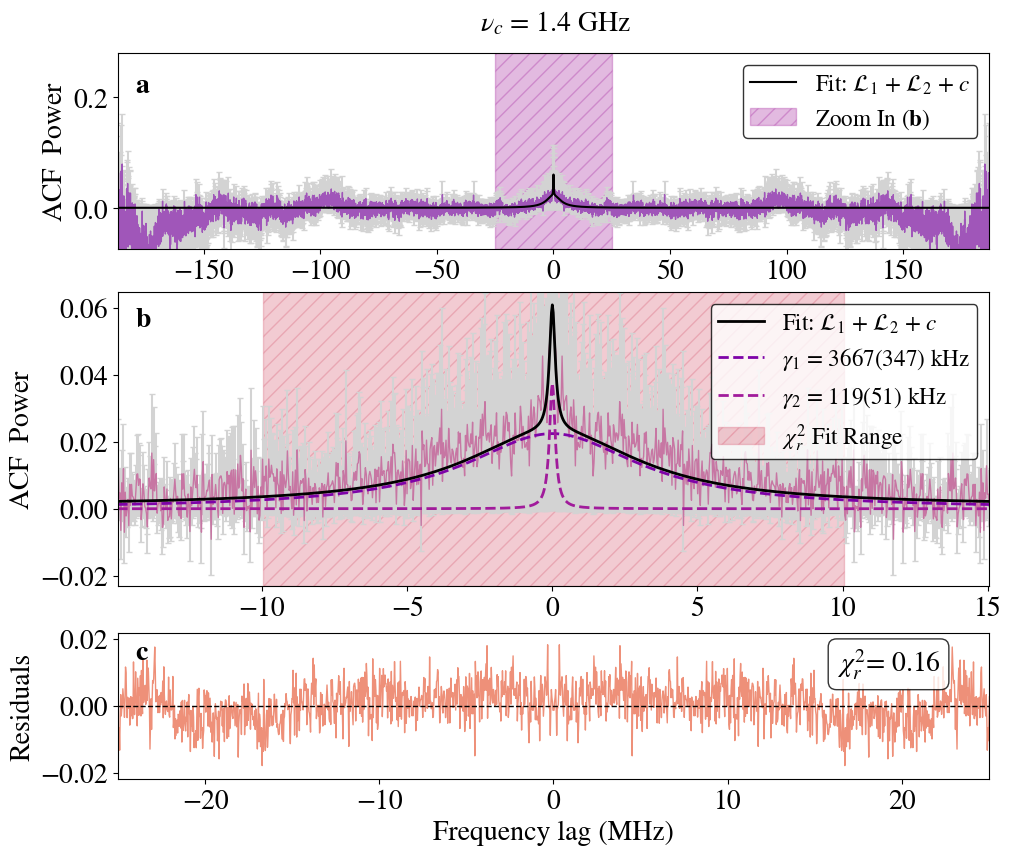

In [10]:
# In a new notebook cell

# 1. Define which saved fit you want to plot
subband_to_plot = 0
model_name_to_plot = "Lorentzian+Lorentzian" # Use the exact name from the dropdowns, e.g., "Lorentzian+Gaussian"

# 2. Get the corresponding ACF data
lags = acf_results["subband_lags_mhz"][subband_to_plot]
lags_list = acf_results["subband_lags_mhz"]
acf_data = acf_results["subband_acfs"][subband_to_plot]
errs_data = acf_results.get("subband_acfs_err", [None]*len(lags_list))[subband_to_plot]
current_acf_obj = ACF(acf_data, lags, acf_err=errs_data)

# 3. Load the fit data from the YAML file
reconstructed_fit = load_fit_from_yaml(
    config_path=BURST_CONFIG_PATH,
    subband_index=subband_to_plot,
    model_name=model_name_to_plot,
    lags=current_acf_obj.lags
)

# 4. Generate the plot
if reconstructed_fit:
    plot_publication_acf(
        acf_obj=current_acf_obj,
        best_fit_curve=reconstructed_fit["best_fit_curve"],
        component_curves=reconstructed_fit["component_curves"],
        redchi=reconstructed_fit["redchi"],
        params=reconstructed_fit["params"], # <-- Pass the newly available params dict
        fit_range_mhz=reconstructed_fit["fit_range_mhz"]
    )

In [ ]:
# In scint_analysis/plotting.py
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm # Import the colormap module
plt.rcParams['font.size'] = 16

# In scint_analysis/plotting.py

def plot_stacked_acfs(
    acf_results: dict,
    all_fits: dict = None,
    model_name_to_plot: str = None,
    zoom_mhz: float = 2.0,
    offset_factor: float = 0.8,
    amplification_factor: float = 1.0,
    save_path: str = None
):
    """
    Plots the sub-band ACFs as a vertically stacked series of line plots with error bars.
    """
    lags_list = acf_results['subband_lags_mhz']
    acfs_list = acf_results['subband_acfs']
    # Retrieve the error arrays, with a fallback to None if they don't exist
    errs_list = acf_results.get('subband_acfs_err', [None] * len(acfs_list))
    freqs = acf_results['subband_center_freqs_mhz']
    num_subbands = len(freqs)

    fig, ax = plt.subplots(figsize=(8, 10))
    cmap = cm.get_cmap('plasma')
    def mid_cmap(val):
        # Restrict val to [0,1], then map to [0.25,0.75] for the middle half
        return cmap(0.25 + 0.5 * np.clip(val, 0, 1))

    max_acf_val = 0
    for i, acf in enumerate(acfs_list):
        lags = lags_list[i]
        mask = (lags != 0)
        if len(acf[mask]) > 0:
             max_acf_val = max(max_acf_val, np.max(acf[mask]))
    if max_acf_val == 0: max_acf_val = 1.0
    
    vertical_offset = (max_acf_val * amplification_factor) * offset_factor

    # --- Loop through sub-bands and plot ---
    for i in range(num_subbands):
        lags = lags_list[i]
        acf = acfs_list[i]
        errs = errs_list[i]
        offset = i * vertical_offset
        color = mid_cmap(i / (num_subbands - 1) if num_subbands > 1 else 0.5)
        mask = (lags != 0)

        # --- MODIFIED SECTION: Use ax.errorbar ---
        if errs is not None:
            ax.errorbar(
                lags[mask],
                (acf * amplification_factor + offset)[mask],
                yerr=(errs * amplification_factor)[mask], # Scale the errors
                fmt='.',           # Plot markers instead of a connected line
                ms=2.0,            # Marker size
                color=color,
                alpha=0.7,
                capsize=2.0        # Size of the error bar caps
            )
        else:
            # Fallback to a simple line plot if no errors are available
            ax.plot(lags[mask], (acf * amplification_factor + offset)[mask], color=color, lw=1.0)
        # --- END MODIFIED SECTION ---
        
        # Plot the fit if available (amplified)
        if all_fits and model_name_to_plot:
            model_tuple = tuple(model_name_to_plot.split('+'))
            fit_key = (i, model_tuple)
            if fit_key in all_fits:
                fit_result = all_fits[fit_key]
                fit_curve = fit_result.eval(x=lags)
                ax.plot(lags[mask], (fit_curve * amplification_factor + offset)[mask], 'k-', lw=1.5, alpha=0.9)

    # --- Final Touches (unchanged) ---
    ax.set_xlabel('Frequency Lag (MHz)')
    ax.set_ylabel('Center Frequency (MHz)')
    ax.set_title('S/N Sub-banded ACF Fits (Wilhelm)')
    
    tick_locs = [i * vertical_offset for i in range(num_subbands)]
    ax.set_yticks(tick_locs)
    ax.set_yticklabels([f"{f:.0f}" for f in freqs])
    
    ax.set_xlim(-zoom_mhz, zoom_mhz)
    ax.set_ylim(-0.1*max_acf_val, 0.85*max_acf_val)
    ax.grid(True, linestyle=':', alpha=0.5)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

#def plot_stacked_acfs(
#    acf_results: dict,
#    all_fits: dict = None,
#    model_name_to_plot: str = None,
#    zoom_mhz: float = 2.0,
#    offset_factor: float = 0.8,
#    save_path: str = None
#):
#    """
#    Plots the sub-band ACFs as a vertically stacked series of line plots,
#    with the zero-lag point masked.
#    """
#    lags_list = acf_results['subband_lags_mhz']
#    acfs_list = acf_results['subband_acfs']
#    freqs = acf_results['subband_center_freqs_mhz']
#    num_subbands = len(freqs)
#
#    fig, ax = plt.subplots(figsize=(8, 10))
#    cmap = cm.get_cmap('plasma')
#    def mid_cmap(val):
#        # Restrict val to [0,1], then map to [0.25,0.75] for the middle half
#        return cmap(0.25 + 0.5 * np.clip(val, 0, 1))
#
#    max_acf_val = 0
#    for i, acf in enumerate(acfs_list):
#        lags = lags_list[i]
#        mask = (lags != 0)
#        if len(acf[mask]) > 0:
#             max_acf_val = max(max_acf_val, np.max(acf[mask]))
#    if max_acf_val == 0: max_acf_val = 1.0
#    
#    vertical_offset = max_acf_val * offset_factor
#
#    # --- Loop through sub-bands and plot ---
#    for i in range(num_subbands):
#        lags = lags_list[i]
#        acf = acfs_list[i]
#        offset = i * vertical_offset
#        color = mid_cmap(i / (num_subbands - 1) if num_subbands > 1 else 0.5)
#
#        # --- CREATE MASK TO EXCLUDE ZERO LAG ---
#        mask = (lags != 0)
#
#        # Plot the data using the mask
#        ax.plot(lags[mask], (acf + offset)[mask], color=color, lw=1.0)
#        
#        # Plot the fit if available, also using the mask
#        if all_fits and model_name_to_plot:
#            model_tuple = tuple(model_name_to_plot.split('+'))
#            fit_key = (i, model_tuple)
#            if fit_key in all_fits:
#                fit_result = all_fits[fit_key]
#                fit_curve = fit_result.eval(x=lags)
#                ax.plot(lags[mask], (fit_curve + offset)[mask], 'k-', lw=1.5, alpha=0.8)
#
#    # --- Final Touches ---
#    ax.set_xlabel('Frequency Lag (MHz)')
#    ax.set_ylabel('Center Frequency (MHz)')
#    ax.set_title('S/N Sub-banded ACF Fits (Zach)')
#    
#    tick_locs = [i * vertical_offset for i in range(num_subbands)]
#    ax.set_yticks(tick_locs)
#    ax.set_yticklabels([f"{f:.0f}" for f in freqs])
#    
#    ax.set_xlim(-zoom_mhz, zoom_mhz)
#    ax.set_ylim(-0.1*max_acf_val, 0.4*max_acf_val)
#    ax.grid(True, linestyle=':', alpha=0.5)
#    
#    if save_path:
#        plt.savefig(save_path, dpi=300, bbox_inches='tight')
#    
#    plt.show()
#

/var/folders/8s/v8lmbgcx6d73pbwjmbf198d80000gn/T/ipykernel_98941/432940323.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma')


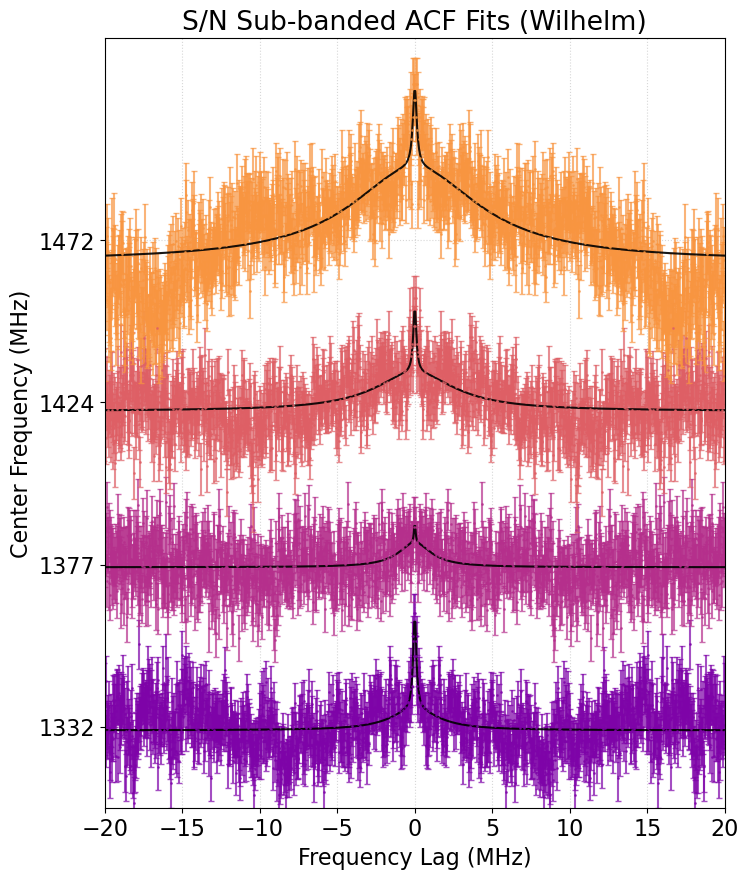

In [120]:
# In scint_analysis/plotting.py
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm


plot_stacked_acfs(
    acf_results=scint_pipeline.acf_results,
    all_fits=all_fits,
    model_name_to_plot="Lorentzian+Lorentzian",
    zoom_mhz=20.0,
    offset_factor=0.2) 

In [ ]:
# In scint_analysis/plotting.py
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm # Import the colormap module
plt.rcParams['font.size'] = 16

# In scint_analysis/plotting.py

def plot_stacked_acfs(
    acf_results: dict,
    all_fits: dict = None,
    model_name_to_plot: str = None,
    zoom_mhz: float = 2.0,
    offset_factor: float = 0.8,
    amplification_factor: float = 1.0,
    save_path: str = None
):
    """
    Plots the sub-band ACFs as a vertically stacked series of line plots with error bars.
    """
    lags_list = acf_results['subband_lags_mhz']
    acfs_list = acf_results['subband_acfs']
    # Retrieve the error arrays, with a fallback to None if they don't exist
    errs_list = acf_results.get('subband_acfs_err', [None] * len(acfs_list))
    freqs = acf_results['subband_center_freqs_mhz']
    num_subbands = len(freqs)

    fig, ax = plt.subplots(figsize=(8, 10))
    cmap = cm.get_cmap('plasma')
    def mid_cmap(val):
        # Restrict val to [0,1], then map to [0.25,0.75] for the middle half
        return cmap(0.25 + 0.5 * np.clip(val, 0, 1))

    max_acf_val = 0
    for i, acf in enumerate(acfs_list):
        lags = lags_list[i]
        mask = (lags != 0)
        if len(acf[mask]) > 0:
             max_acf_val = max(max_acf_val, np.max(acf[mask]))
    if max_acf_val == 0: max_acf_val = 1.0
    
    vertical_offset = (max_acf_val * amplification_factor) * offset_factor

    # --- Loop through sub-bands and plot ---
    for i in range(num_subbands):
        lags = lags_list[i]
        acf = acfs_list[i]
        errs = errs_list[i]
        offset = i * vertical_offset
        color = mid_cmap(i / (num_subbands - 1) if num_subbands > 1 else 0.5)
        mask = (lags != 0)

        # --- MODIFIED SECTION: Use ax.errorbar ---
        if errs is not None:
            ax.errorbar(
                lags[mask],
                (acf * amplification_factor + offset)[mask],
                yerr=(errs * amplification_factor)[mask], # Scale the errors
                fmt='.',           # Plot markers instead of a connected line
                ms=2.0,            # Marker size
                color=color,
                alpha=0.7,
                capsize=2.0        # Size of the error bar caps
            )
        else:
            # Fallback to a simple line plot if no errors are available
            ax.plot(lags[mask], (acf * amplification_factor + offset)[mask], color=color, lw=1.0)
        # --- END MODIFIED SECTION ---
        
        # Plot the fit if available (amplified)
        if all_fits and model_name_to_plot:
            model_tuple = tuple(model_name_to_plot.split('+'))
            fit_key = (i, model_tuple)
            if fit_key in all_fits:
                fit_result = all_fits[fit_key]
                fit_curve = fit_result.eval(x=lags)
                ax.plot(lags[mask], (fit_curve * amplification_factor + offset)[mask], 'k-', lw=1.5, alpha=0.9)

    # --- Final Touches (unchanged) ---
    ax.set_xlabel('Frequency Lag (MHz)')
    ax.set_ylabel('Center Frequency (MHz)  [Offset Stacked]')
    ax.set_title('S/N Sub-banded ACF Fits (Zach)')
    
    tick_locs = [i * vertical_offset for i in range(num_subbands)]
    ax.set_yticks(tick_locs)
    ax.set_yticklabels([f"{f:.0f}" for f in freqs])
    
    ax.set_xlim(-zoom_mhz, zoom_mhz)
    ax.set_ylim(-0.1*max_acf_val, 0.4*max_acf_val)
    ax.grid(True, linestyle=':', alpha=0.5)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

#def plot_stacked_acfs(
#    acf_results: dict,
#    all_fits: dict = None,
#    model_name_to_plot: str = None,
#    zoom_mhz: float = 2.0,
#    offset_factor: float = 0.8,
#    save_path: str = None
#):
#    """
#    Plots the sub-band ACFs as a vertically stacked series of line plots,
#    with the zero-lag point masked.
#    """
#    lags_list = acf_results['subband_lags_mhz']
#    acfs_list = acf_results['subband_acfs']
#    freqs = acf_results['subband_center_freqs_mhz']
#    num_subbands = len(freqs)
#
#    fig, ax = plt.subplots(figsize=(8, 10))
#    cmap = cm.get_cmap('plasma')
#    def mid_cmap(val):
#        # Restrict val to [0,1], then map to [0.25,0.75] for the middle half
#        return cmap(0.25 + 0.5 * np.clip(val, 0, 1))
#
#    max_acf_val = 0
#    for i, acf in enumerate(acfs_list):
#        lags = lags_list[i]
#        mask = (lags != 0)
#        if len(acf[mask]) > 0:
#             max_acf_val = max(max_acf_val, np.max(acf[mask]))
#    if max_acf_val == 0: max_acf_val = 1.0
#    
#    vertical_offset = max_acf_val * offset_factor
#
#    # --- Loop through sub-bands and plot ---
#    for i in range(num_subbands):
#        lags = lags_list[i]
#        acf = acfs_list[i]
#        offset = i * vertical_offset
#        color = mid_cmap(i / (num_subbands - 1) if num_subbands > 1 else 0.5)
#
#        # --- CREATE MASK TO EXCLUDE ZERO LAG ---
#        mask = (lags != 0)
#
#        # Plot the data using the mask
#        ax.plot(lags[mask], (acf + offset)[mask], color=color, lw=1.0)
#        
#        # Plot the fit if available, also using the mask
#        if all_fits and model_name_to_plot:
#            model_tuple = tuple(model_name_to_plot.split('+'))
#            fit_key = (i, model_tuple)
#            if fit_key in all_fits:
#                fit_result = all_fits[fit_key]
#                fit_curve = fit_result.eval(x=lags)
#                ax.plot(lags[mask], (fit_curve + offset)[mask], 'k-', lw=1.5, alpha=0.8)
#
#    # --- Final Touches ---
#    ax.set_xlabel('Frequency Lag (MHz)')
#    ax.set_ylabel('Center Frequency (MHz)')
#    ax.set_title('S/N Sub-banded ACF Fits (Zach)')
#    
#    tick_locs = [i * vertical_offset for i in range(num_subbands)]
#    ax.set_yticks(tick_locs)
#    ax.set_yticklabels([f"{f:.0f}" for f in freqs])
#    
#    ax.set_xlim(-zoom_mhz, zoom_mhz)
#    ax.set_ylim(-0.1*max_acf_val, 0.4*max_acf_val)
#    ax.grid(True, linestyle=':', alpha=0.5)
#    
#    if save_path:
#        plt.savefig(save_path, dpi=300, bbox_inches='tight')
#    
#    plt.show()
#

In [85]:
# ==============================================================================
# Manual ACF Fitting Notebook
# ==============================================================================
# This notebook allows for manual, interactive fitting of sub-banded ACFs
# independent of the main automated pipeline, using the lmfit library for
# consistency with the main pipeline.

# Imports 
import pickle
import numpy as np
import matplotlib.pyplot as plt
import yaml 
from lmfit import Model # Using lmfit instead of scipy.curve_fit

# Imports for Interactive Controls
from ipywidgets import interact, IntSlider, FloatSlider, FloatRangeSlider, FloatText, Dropdown, VBox, HBox, Button, Output, Textarea, Label, Checkbox
from IPython.display import display

# Imports from your Scintillation Analysis Pipeline
try:
    from scint_analysis.analysis import (
        lorentzian_model_1_comp,
        lorentzian_model_2_comp,
        lorentzian_model_3_comp
    )
    from scint_analysis.core import ACF
except ImportError as e:
    print(f"Error: Could not import from scint_analysis package. Make sure it is installed or in the Python path. {e}")

# Load Pre-Calculated ACF Data
ACF_RESULTS_PATH = '/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/wilhelm/wilhelm_acf_results.pkl'

with open(ACF_RESULTS_PATH, 'rb') as f:
    acf_results = pickle.load(f)
print(f"Successfully loaded ACF results from '{ACF_RESULTS_PATH}'")
num_subbands = len(acf_results['subband_acfs'])
print(f"Found data for {num_subbands} sub-bands.")


# Model Configuration Hub
MODEL_CONFIG = {
    '1-Component Lorentzian': {
        'func': lorentzian_model_1_comp,
        'prefix': 'l1_',
        'param_names': ['gamma1', 'm1', 'c1'],
        'hook': lambda p: (p['l1_gamma1'].set(min=1e-6), p['l1_m1'].set(min=0))
    },
    '2-Component Lorentzian': {
        'func': lorentzian_model_2_comp,
        'prefix': 'l2_',
        'param_names': ['gamma1', 'm1', 'gamma2', 'm2', 'c2'],
        'hook': lambda p: (
            p['l2_gamma1'].set(min=1e-6), p['l2_gamma2'].set(min=1e-6),
            p['l2_m1'].set(min=0), p['l2_m2'].set(min=0))
    },
    '3-Component Lorentzian': {
        'func': lorentzian_model_3_comp,
        'prefix': 'l3_',
        'param_names': ['gamma1', 'm1', 'gamma2', 'm2', 'gamma3', 'm3', 'c3'],
        'hook': lambda p: (
            p['l3_gamma1'].set(min=1e-6), p['l3_gamma2'].set(min=1e-6), p['l3_gamma3'].set(min=1e-6),
            p['l3_m1'].set(min=0), p['l3_m2'].set(min=0), p['l3_m3'].set(min=0))
    }
}


# Main Interactive Fitting Function
if acf_results:
    # Create Widgets
    subband_slider = IntSlider(min=0, max=num_subbands-1, step=1, value=0, description='Sub-band Index:')
    model_selector = Dropdown(options=MODEL_CONFIG.keys(), value='2-Component Lorentzian', description='Model:')
    max_lag_overall = max(np.max(np.abs(lags)) for lags in acf_results['subband_lags_mhz'])
    
    fit_range_min_text = FloatText(value=-max_lag_overall, description='Min Lag:')
    fit_range_max_text = FloatText(value=max_lag_overall, description='Max Lag:')
    
    fit_range_slider = FloatRangeSlider(
        value=[-max_lag_overall, max_lag_overall],
        min=-max_lag_overall,
        max=max_lag_overall,
        step=0.1,
        description='Fit Range Slider:',
        continuous_update=False, 
        style={'description_width': 'initial'}
    )

    # Checkbox to control use of uncertainties
    ignore_errors_checkbox = Checkbox(value=False, description="Ignore Pre-calculated Uncertainties", indent=False)
    
    fit_button = Button(description="Perform Fit", button_style='success', icon='cogs')
    print_fits_button = Button(description="Print Stored Fits", button_style='info', icon='print')
    update_yaml_button = Button(description="Save Evolving Guess to YAML", button_style='warning', icon='save')
    
    param_controls_container = VBox([])
    plot_output = Output()
    results_output_area = Textarea(layout={'width': '98%', 'height': '200px'}, placeholder="Results from 'Print Stored Fits' will appear here.")
    status_label = Label(value="")
    fit_stats_label = Label(value="Fit Stats: N/A")

    all_fits_storage = {}

    def create_param_controls(model_name):
        config = MODEL_CONFIG[model_name]
        param_names = config['param_names']
        all_param_widgets = []
        num_components = (len(param_names) - 1) // 2
        
        for i in range(num_components):
            gamma_name = config['prefix'] + param_names[i*2]
            m_name = config['prefix'] + param_names[i*2 + 1]
            gamma_slider = FloatSlider(min=0, max=15, step=0.01, value=0.1, description=f'{gamma_name}:')
            m_slider = FloatSlider(min=0, max=2, step=0.01, value=0.5, description=f'{m_name}:')
            alpha_box = FloatText(value=4.0, description=f'{gamma_name} α:')
            component_box = HBox([gamma_slider, m_slider, alpha_box])
            all_param_widgets.append(component_box)

        c_name = config['prefix'] + param_names[-1]
        c_slider = FloatSlider(min=-0.2, max=0.2, step=0.001, value=0.0, description=f'{c_name}:')
        all_param_widgets.append(c_slider)
        param_controls_container.children = tuple(all_param_widgets)
        
        for box in all_param_widgets:
            if isinstance(box, HBox):
                for widget in box.children: widget.observe(on_visuals_change, names='value')
            else:
                box.observe(on_visuals_change, names='value')

    def get_current_params():
        params = []
        for box in param_controls_container.children:
            if isinstance(box, HBox): params.extend([box.children[0].value, box.children[1].value])
            else: params.append(box.value)
        return params

    def draw_plot(subband_idx, model_name, fit_range, initial_guesses, fit_result=None):
        with plot_output:
            plot_output.clear_output(wait=True)
            config = MODEL_CONFIG[model_name]
            model_func = config['func']
            
            center_freq = acf_results['subband_center_freqs_mhz'][subband_idx]
            lags, acf_data, acf_err = acf_results['subband_lags_mhz'][subband_idx], acf_results['subband_acfs'][subband_idx], acf_results.get('subband_acfs_err', [None]*num_subbands)[subband_idx]
            
            range_mask = (lags >= fit_range[0]) & (lags <= fit_range[1]) & (lags != 0)
            x_data, y_data = lags[range_mask], acf_data[range_mask]

            fig, ax = plt.subplots(figsize=(10, 6))
            ax.errorbar(lags, acf_data, yerr=acf_err, fmt='.', color='lightgray', label='All Data', capsize=3, alpha=0.5, zorder=1)
            ax.plot(x_data, y_data, '-', color='purple', alpha=0.5, label='Data in Fit Range')
            ax.axvspan(fit_range[0], fit_range[1], color='gray', alpha=0., zorder=0)

            y_guess = model_func(x_data, *initial_guesses)
            ax.plot(x_data, y_guess, '-', color='pink', label='Initial Guess', zorder=5)

            if fit_result and fit_result.success:
                ax.plot(x_data, fit_result.best_fit, 'k-', label='Final Fit', lw=2, zorder=10)

            ax.set_title(f"Assisted Fit for Sub-band {subband_idx} @ {center_freq:.2f} MHz ({model_name})")
            ax.set_xlabel("Frequency Lag (MHz)"), ax.set_ylabel("Correlation"), ax.set_ylim(-0.05, 0.1)
            ax.grid(True, linestyle=':'), ax.legend(loc='upper right')
            ax.set_xlim(fit_range[0]-2, fit_range[1]+2)
            ax.set_ylim(np.min(y_data)-0.05, np.max(y_data)+0.05)
            plt.show()

    def on_visuals_change(change):
        # When visuals change, clear the old fit stats
        fit_stats_label.value = "Fit Stats: N/A"
        draw_plot(subband_slider.value, model_selector.value, fit_range_slider.value, get_current_params())

    def on_fit_button_clicked(b):
        subband_idx, model_name, fit_range = subband_slider.value, model_selector.value, fit_range_slider.value
        initial_guesses = get_current_params()
        config = MODEL_CONFIG[model_name]
        
        lags, acf_data, acf_err = acf_results['subband_lags_mhz'][subband_idx], acf_results['subband_acfs'][subband_idx], acf_results.get('subband_acfs_err', [None]*num_subbands)[subband_idx]
        range_mask = (lags >= fit_range[0]) & (lags <= fit_range[1]) & (lags != 0)
        x_data, y_data = lags[range_mask], acf_data[range_mask]
        
        # Handle sigma based on checkbox 
        sigma = None
        avg_sigma_str = "N/A"
        # Only use sigma if the checkbox is NOT checked and errors exist
        if not ignore_errors_checkbox.value and acf_err is not None:
            sigma = acf_err[range_mask]
            # Calculate average sigma for display
            if sigma.size > 0:
                avg_sigma_str = f"{np.mean(sigma):.4f}"

        model = Model(config['func'], prefix=config['prefix'])
        params = model.make_params()
        for name, value in zip(config['param_names'], initial_guesses):
            params[config['prefix'] + name].set(value=value)
        if config.get('hook'):
            config['hook'](params)
        
        fit_result = None
        try:
            # Pass weights correctly
            weights = 1.0/sigma if sigma is not None else None
            fit_result = model.fit(y_data, params, x=x_data, weights=weights)

            if fit_result.success:
                all_fits_storage[subband_idx] = {'result': fit_result, 'model_name': model_name}
                fit_stats_label.value = f"Fit Stats: Avg. σ = {avg_sigma_str} | Reduced Chi-sq = {fit_result.redchi:.3f} | BIC = {fit_result.bic:.2f}"
            else:
                fit_stats_label.value = "Fit Stats: Fit did not converge."

        except Exception as e:
            fit_stats_label.value = f"Fit Stats: Error - {e}"
        
        draw_plot(subband_idx, model_name, fit_range, initial_guesses, fit_result=fit_result)


    def on_print_fits_clicked(b):
        output_str = ""
        for idx in sorted(all_fits_storage.keys()):
            fit_info = all_fits_storage[idx]
            result = fit_info['result']
            center_freq = acf_results['subband_center_freqs_mhz'][idx]
            output_str += f"--- Sub-band {idx} @ {center_freq:.2f} MHz (Model: {fit_info['model_name']}) ---\n"
            for name, param in result.params.items():
                output_str += f"  {name}: {param.value:.4f} +/- {param.stderr or 0.0:.4f}\n"
            output_str += "\n"
        results_output_area.value = output_str

    def on_update_yaml_clicked(b):
        try:
            subband_idx = subband_slider.value
            if subband_idx not in all_fits_storage:
                status_label.value = f"Error: No successful fit found for sub-band {subband_idx}. Please 'Perform Fit' first."
                return

            status_label.value = "Updating YAML file with best-fit parameters..."
            fit_info = all_fits_storage[subband_idx]
            result = fit_info['result']
            model_name_str = fit_info['model_name']
            
            center_freq = acf_results['subband_center_freqs_mhz'][subband_idx]
            model_key = model_name_str.replace('-Component Lorentzian', 'c_lor').replace(' ', '')
            
            evolving_guess_dict = {'reference_frequency_mhz': center_freq, 'components': [], 'constants': {}}
            component_widgets = [child for child in param_controls_container.children if isinstance(child, HBox)]
            
            for i, comp_box in enumerate(component_widgets):
                prefix = MODEL_CONFIG[model_name_str]['prefix']
                gamma_name = prefix + MODEL_CONFIG[model_name_str]['param_names'][i*2]
                m_name = prefix + MODEL_CONFIG[model_name_str]['param_names'][i*2 + 1]
                
                evolving_guess_dict['components'].append({
                    'name': f'component_{i+1}',
                    'gamma_guess': float(f"{result.params[gamma_name].value:.4f}"),
                    'gamma_scaling_index': comp_box.children[2].value,
                    'm_guess': float(f"{result.params[m_name].value:.4f}")
                })

            prefix = MODEL_CONFIG[model_name_str]['prefix']
            c_name_short = MODEL_CONFIG[model_name_str]['param_names'][-1]
            c_name_full = prefix + c_name_short
            evolving_guess_dict['constants'][c_name_short] = float(f"{result.params[c_name_full].value:.4f}")

            CONFIG_PATH = BURST_CONFIG_PATH
            with open(CONFIG_PATH, 'r') as f: config_data = yaml.safe_load(f)
            init_guess_section = config_data.setdefault('analysis', {}).setdefault('fitting', {}).setdefault('init_guess', {})
            init_guess_section[model_key] = evolving_guess_dict
            with open(CONFIG_PATH, 'w') as f: yaml.dump(config_data, f, default_flow_style=False, sort_keys=False)
            status_label.value = f"Success! Updated '{model_key}' guess in {CONFIG_PATH}."
        except Exception as e:
            status_label.value = f"Error: {e}"

    def on_model_change(change):
        create_param_controls(change['new'])
        on_visuals_change(None)

    def link_text_to_slider(change):
        min_val, max_val = fit_range_min_text.value, fit_range_max_text.value
        if min_val < max_val:
            fit_range_slider.unobserve(link_slider_to_text, names='value')
            fit_range_slider.value = (min_val, max_val)
            fit_range_slider.observe(link_slider_to_text, names='value')
            on_visuals_change(None)

    def link_slider_to_text(change):
        fit_range_min_text.value, fit_range_max_text.value = round(change.new[0], 2), round(change.new[1], 2)
        on_visuals_change(None)

    # --- Link Widgets ---
    subband_slider.observe(on_visuals_change, names='value')
    model_selector.observe(on_model_change, names='value')
    fit_button.on_click(on_fit_button_clicked)
    print_fits_button.on_click(on_print_fits_clicked)
    update_yaml_button.on_click(on_update_yaml_clicked)
    fit_range_slider.observe(link_slider_to_text, names='value')
    fit_range_min_text.observe(link_text_to_slider, names='value')
    fit_range_max_text.observe(link_text_to_slider, names='value')
    
    # --- Display Dashboard ---
    create_param_controls(model_selector.value)
    
    fit_range_controls = VBox([Label(value="Fit Lag Range (MHz):"), HBox([fit_range_min_text, fit_range_max_text]), fit_range_slider])
    
    # Add the new fit_stats_label to the layout
    dashboard = VBox([
        HBox([subband_slider, model_selector]), 
        fit_range_controls, 
        Label(value="Component Parameters (gamma, m, alpha) and Constants (c):"), 
        param_controls_container, 
        HBox([fit_button, print_fits_button, update_yaml_button]), 
        status_label, 
        fit_stats_label,
        plot_output, 
        results_output_area
    ])
    display(dashboard)
    on_visuals_change(None)


Error: Could not import from scint_analysis package. Make sure it is installed or in the Python path. cannot import name 'lorentzian_model_1_comp' from 'scint_analysis.analysis' (/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/scint_analysis/analysis.py)
Successfully loaded ACF results from '/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/wilhelm/wilhelm_acf_results.pkl'
Found data for 4 sub-bands.


In [10]:
## ==============================================================================
## Manual ACF Fitting Notebook
## ==============================================================================
## This notebook allows for manual, interactive fitting of sub-banded ACFs
## independent of the main automated pipeline.
#
## --- Cell 1: Imports ---
#import pickle
#import numpy as np
#import matplotlib.pyplot as plt
#from scipy.optimize import curve_fit
#import yaml # Added for writing to config file
#
## --- Imports for Interactive Controls ---
#from ipywidgets import interact, IntSlider, FloatSlider, FloatRangeSlider, FloatText, Dropdown, VBox, HBox, Button, Output, Textarea, Label
#from IPython.display import display
#
## --- Imports from your Scintillation Analysis Pipeline ---
## Ensure the scint_analysis package is in your Python path
#try:
#    from scint_analysis.analysis import (
#        lorentzian_model_1_comp,
#        lorentzian_model_2_comp,
#        lorentzian_model_3_comp
#    )
#    from scint_analysis.core import ACF
#except ImportError as e:
#    print(f"Error: Could not import from scint_analysis package. Make sure it is installed or in the Python path. {e}")
#
## --- Cell 2: Load Pre-Calculated ACF Data ---
#ACF_RESULTS_PATH = '/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/zach/zach_acf_results.pkl' # Using your specified path
#
## Using with...open is safer, but respecting the user's edit to remove the try/except block for now.
#with open(ACF_RESULTS_PATH, 'rb') as f:
#    acf_results = pickle.load(f)
#print(f"Successfully loaded ACF results from '{ACF_RESULTS_PATH}'")
#num_subbands = len(acf_results['subband_acfs'])
#print(f"Found data for {num_subbands} sub-bands.")
#
#
## --- Cell 3: Model Configuration Hub ---
## This dictionary maps model names to their functions and parameter details.
#MODEL_CONFIG = {
#    '1-Component Lorentzian': {
#        'func': lorentzian_model_1_comp,
#        'param_names': ['gamma1', 'm1', 'c1'],
#        'bounds': ([-np.inf, 0, -np.inf], [np.inf, np.inf, np.inf])
#    },
#    '2-Component Lorentzian': {
#        'func': lorentzian_model_2_comp,
#        'param_names': ['gamma1', 'm1', 'gamma2', 'm2', 'c2'],
#        'bounds': ([-np.inf, 0, -np.inf, 0, -np.inf], [np.inf, np.inf, np.inf, np.inf, np.inf])
#    },
#    '3-Component Lorentzian': {
#        'func': lorentzian_model_3_comp,
#        'param_names': ['gamma1', 'm1', 'gamma2', 'm2', 'gamma3', 'm3', 'c3'],
#        'bounds': ([-np.inf, 0, -np.inf, 0, -np.inf, 0, -np.inf], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
#    }
#}
#
#
## --- Cell 4: Main Interactive Fitting Function ---
#if acf_results:
#    # --- Create Widgets ---
#    subband_slider = IntSlider(min=0, max=num_subbands-1, step=1, value=0, description='Sub-band Index:')
#    model_selector = Dropdown(options=MODEL_CONFIG.keys(), value='2-Component Lorentzian', description='Model:')
#    max_lag_overall = max(np.max(np.abs(lags)) for lags in acf_results['subband_lags_mhz'])
#    fit_range_slider = FloatRangeSlider(value=[-max_lag_overall, max_lag_overall], min=-max_lag_overall, max=max_lag_overall, step=0.1, description='Fit Lag Range (MHz):', continuous_update=False, style={'description_width': 'initial'})
#    
#    fit_button = Button(description="Perform Fit", button_style='success', icon='cogs')
#    print_fits_button = Button(description="Print Stored Fits", button_style='info', icon='print')
#    update_yaml_button = Button(description="Save Evolving Guess to YAML", button_style='warning', icon='save')
#    
#    param_controls_container = VBox([]) # Placeholder for all parameter controls
#    plot_output = Output()
#    results_output_area = Textarea(layout={'width': '98%', 'height': '200px'}, placeholder="Results from 'Print Stored Fits' will appear here.")
#    status_label = Label(value="")
#
#    all_fits_storage = {}
#
#    def create_param_controls(model_name):
#        """Dynamically creates sliders and text boxes for the selected model's parameters."""
#        config = MODEL_CONFIG[model_name]
#        param_names = config['param_names']
#        all_param_widgets = []
#        num_components = (len(param_names) - 1) // 2
#        
#        for i in range(num_components):
#            gamma_name = param_names[i*2]
#            m_name = param_names[i*2 + 1]
#            
#            gamma_slider = FloatSlider(min=0, max=15, step=0.01, value=0.1, description=f'{gamma_name}:')
#            m_slider = FloatSlider(min=0, max=2, step=0.01, value=0.5, description=f'{m_name}:')
#            alpha_box = FloatText(value=4.0, description=f'{gamma_name} α:')
#            
#            component_box = HBox([gamma_slider, m_slider, alpha_box])
#            all_param_widgets.append(component_box)
#
#        c_name = param_names[-1]
#        c_slider = FloatSlider(min=-0.2, max=0.2, step=0.001, value=0.0, description=f'{c_name}:')
#        all_param_widgets.append(c_slider)
#
#        param_controls_container.children = tuple(all_param_widgets)
#        
#        for box in all_param_widgets:
#            if isinstance(box, HBox):
#                for widget in box.children:
#                    widget.observe(on_visuals_change, names='value')
#            else:
#                box.observe(on_visuals_change, names='value')
#
#    def get_current_params():
#        """Helper to get all parameter values (gamma, m, c) from the current UI state."""
#        params = []
#        for box in param_controls_container.children:
#            if isinstance(box, HBox):
#                 params.extend([box.children[0].value, box.children[1].value])
#            else:
#                 params.append(box.value)
#        return params
#
#    def draw_plot(subband_idx, model_name, fit_range, initial_guesses, popt=None):
#        with plot_output:
#            plot_output.clear_output(wait=True)
#            config = MODEL_CONFIG[model_name]
#            model_func = config['func']
#            
#            center_freq = acf_results['subband_center_freqs_mhz'][subband_idx]
#            lags = acf_results['subband_lags_mhz'][subband_idx]
#            acf_data = acf_results['subband_acfs'][subband_idx]
#            acf_err = acf_results.get('subband_acfs_err', [None]*num_subbands)[subband_idx]
#            
#            zero_lag_mask = (lags != 0)
#            range_mask = (lags >= fit_range[0]) & (lags <= fit_range[1])
#            final_fit_mask = zero_lag_mask & range_mask
#            
#            x_data, y_data, sigma = lags[final_fit_mask], acf_data[final_fit_mask], acf_err[final_fit_mask] if acf_err is not None else None
#
#            fig, ax = plt.subplots(figsize=(10, 6))
#            ax.errorbar(lags, acf_data, yerr=acf_err, fmt='.', color='lightgray', label='All Data', capsize=3, alpha=0.5, zorder=1)
#            ax.plot(x_data, y_data, 'o', color='purple', alpha=0.2, label='Data in Fit Range')
#            
#            ax.axvspan(fit_range[0], fit_range[1], color='gray', alpha=0.15, zorder=0)
#
#            y_guess = model_func(x_data, *initial_guesses)
#            ax.plot(x_data, y_guess, 'r--', label='Initial Guess', zorder=5)
#
#            if popt is not None:
#                y_fit = model_func(x_data, *popt)
#                ax.plot(x_data, y_fit, 'k-', label='Final Fit', lw=2, zorder=10)
#
#            ax.set_title(f"Manual Fit for Sub-band {subband_idx} @ {center_freq:.2f} MHz ({model_name})")
#            ax.set_xlabel("Frequency Lag (MHz)")
#            ax.set_ylabel("Correlation")
#            ax.set_ylim(-0.05, 0.1)
#            #ax.set_xlim(-10, 10)
#            ax.grid(True, linestyle=':')
#            ax.legend()
#            plt.show()
#
#    def on_visuals_change(change):
#        subband_idx = subband_slider.value
#        model_name = model_selector.value
#        fit_range = fit_range_slider.value
#        initial_guesses = get_current_params()
#        draw_plot(subband_idx, model_name, fit_range, initial_guesses)
#
#    def on_fit_button_clicked(b):
#        subband_idx = subband_slider.value
#        model_name = model_selector.value
#        fit_range = fit_range_slider.value
#        initial_guesses = get_current_params()
#        config = MODEL_CONFIG[model_name]
#        model_func, bounds = config['func'], config['bounds']
#        
#        lags = acf_results['subband_lags_mhz'][subband_idx]
#        acf_data = acf_results['subband_acfs'][subband_idx]
#        acf_err = acf_results.get('subband_acfs_err', [None]*num_subbands)[subband_idx]
#        
#        zero_lag_mask = (lags != 0)
#        range_mask = (lags >= fit_range[0]) & (lags <= fit_range[1])
#        final_fit_mask = zero_lag_mask & range_mask
#        
#        x_data, y_data, sigma = lags[final_fit_mask], acf_data[final_fit_mask], acf_err[final_fit_mask] if acf_err is not None else None
#        
#        popt, pcov = None, None
#        try:
#            popt, pcov = curve_fit(model_func, x_data, y_data, p0=initial_guesses, sigma=sigma, bounds=bounds, maxfev=5000)
#            all_fits_storage[subband_idx] = {'popt': popt, 'pcov': pcov, 'model_name': model_name}
#        except RuntimeError:
#            print("Fit failed to converge. Try different initial guesses.")
#        except ValueError as e:
#            print(f"Fit failed due to a value error: {e}")
#        
#        draw_plot(subband_idx, model_name, fit_range, initial_guesses, popt=popt)
#
#    def on_print_fits_clicked(b):
#        output_str = ""
#        sorted_indices = sorted(all_fits_storage.keys())
#        for idx in sorted_indices:
#            fit_info = all_fits_storage[idx]
#            model_name = fit_info['model_name']
#            popt = fit_info['popt']
#            pcov = fit_info['pcov']
#            
#            perr = np.sqrt(np.diag(pcov))
#            center_freq = acf_results['subband_center_freqs_mhz'][idx]
#            param_names = MODEL_CONFIG[model_name]['param_names']
#            
#            output_str += f"--- Sub-band {idx} @ {center_freq:.2f} MHz (Model: {model_name}) ---\n"
#            for name, val, err in zip(param_names, popt, perr):
#                output_str += f"  {name}: {val:.4f} +/- {err:.4f}\n"
#            output_str += "\n"
#        
#        results_output_area.value = output_str
#
#    def on_update_yaml_clicked(b):
#        try:
#            subband_idx = subband_slider.value
#
#            # Check if a fit exists for the current sub-band
#            if subband_idx not in all_fits_storage:
#                status_label.value = f"Error: No successful fit found for sub-band {subband_idx}. Please 'Perform Fit' first."
#                return
#
#            status_label.value = "Updating YAML file with best-fit parameters..."
#            
#            # Get stored fit info for the current sub-band
#            fit_info = all_fits_storage[subband_idx]
#            model_name_str = fit_info['model_name']
#            popt = fit_info['popt']
#            
#            center_freq = acf_results['subband_center_freqs_mhz'][subband_idx]
#            model_key = model_name_str.replace('-Component Lorentzian', 'c_lor').replace(' ', '')
#            
#            evolving_guess_dict = {
#                'reference_frequency_mhz': center_freq,
#                'components': [],
#                'constants': {}
#            }
#
#            component_widgets = [child for child in param_controls_container.children if isinstance(child, HBox)]
#            constant_widget = [child for child in param_controls_container.children if isinstance(child, FloatSlider) and 'c' in child.description][0]
#            
#            num_components = len(component_widgets)
#
#            for i in range(num_components):
#                # Get gamma and m from the best-fit parameters (popt)
#                gamma_val = popt[i*2]
#                m_val = popt[i*2 + 1]
#                # Get alpha from the UI, as it's a theoretical input
#                alpha_val = component_widgets[i].children[2].value
#                
#                evolving_guess_dict['components'].append({
#                    'name': f'component_{i+1}',
#                    'gamma_guess': float(f"{gamma_val:.4f}"),
#                    'gamma_scaling_index': alpha_val,
#                    'm_guess': float(f"{m_val:.4f}")
#                })
#
#            # The constant 'c' is the last parameter in popt
#            c_val = popt[-1]
#            evolving_guess_dict['constants'][constant_widget.description.replace(':', '')] = float(f"{c_val:.4f}")
#
#            CONFIG_PATH = BURST_CONFIG_PATH # Using zach config
#            with open(CONFIG_PATH, 'r') as f:
#                config_data = yaml.safe_load(f)
#            
#            init_guess_section = config_data.setdefault('analysis', {}).setdefault('fitting', {}).setdefault('init_guess', {})
#            init_guess_section[model_key] = evolving_guess_dict
#            
#            with open(CONFIG_PATH, 'w') as f:
#                yaml.dump(config_data, f, default_flow_style=False, sort_keys=False)
#            
#            status_label.value = f"Success! Updated '{model_key}' guess in {CONFIG_PATH} with best-fit parameters."
#
#        except Exception as e:
#            status_label.value = f"Error: {e}"
#
#    def on_model_change(change):
#        create_param_controls(change['new'])
#        on_visuals_change(None)
#
#    # --- Link Widgets to Functions ---
#    subband_slider.observe(on_visuals_change, names='value')
#    model_selector.observe(on_model_change, names='value')
#    fit_range_slider.observe(on_visuals_change, names='value')
#    fit_button.on_click(on_fit_button_clicked)
#    print_fits_button.on_click(on_print_fits_clicked)
#    update_yaml_button.on_click(on_update_yaml_clicked)
#
#    # --- Display Dashboard ---
#    create_param_controls(model_selector.value)
#    
#    dashboard = VBox([
#        HBox([subband_slider, model_selector]),
#        fit_range_slider,
#        Label(value="Component Parameters (gamma, m, alpha) and Constants (c):"),
#        param_controls_container,
#        HBox([fit_button, print_fits_button, update_yaml_button]),
#        status_label,
#        plot_output,
#        results_output_area
#    ])
#    display(dashboard)
#    
#    on_visuals_change(None)
#
#

In [62]:
# ==============================================================================
# Manual ACF Fitting Notebook (lmfit Version)
# ==============================================================================
# This notebook allows for manual, interactive fitting of sub-banded ACFs
# independent of the main automated pipeline, using the lmfit library for
# consistency with the main pipeline.

# --- Cell 1: Imports ---
import pickle
import numpy as np
import matplotlib.pyplot as plt
import yaml 
from lmfit import Model # Using lmfit instead of scipy.curve_fit

# --- Imports for Interactive Controls ---
from ipywidgets import interact, IntSlider, FloatSlider, FloatRangeSlider, FloatText, Dropdown, VBox, HBox, Button, Output, Textarea, Label
from IPython.display import display

# --- Imports from your Scintillation Analysis Pipeline ---
try:
    from scint_analysis.analysis import (
        lorentzian_model_1_comp,
        lorentzian_model_2_comp,
        lorentzian_model_3_comp
    )
    from scint_analysis.core import ACF
except ImportError as e:
    print(f"Error: Could not import from scint_analysis package. Make sure it is installed or in the Python path. {e}")

# --- Cell 2: Load Pre-Calculated ACF Data ---
ACF_RESULTS_PATH = '/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/zach/zach_acf_results.pkl'

with open(ACF_RESULTS_PATH, 'rb') as f:
    acf_results = pickle.load(f)
print(f"Successfully loaded ACF results from '{ACF_RESULTS_PATH}'")
num_subbands = len(acf_results['subband_acfs'])
print(f"Found data for {num_subbands} sub-bands.")


# --- Cell 3: Model Configuration Hub (lmfit Style) ---
MODEL_CONFIG = {
    '1-Component Lorentzian': {
        'func': lorentzian_model_1_comp,
        'prefix': 'l1_',
        'param_names': ['gamma1', 'm1', 'c1'],
        'hook': lambda p: (p['l1_gamma1'].set(min=1e-6), p['l1_m1'].set(min=0))
    },
    '2-Component Lorentzian': {
        'func': lorentzian_model_2_comp,
        'prefix': 'l2_',
        'param_names': ['gamma1', 'm1', 'gamma2', 'm2', 'c2'],
        'hook': lambda p: (
            p['l2_gamma1'].set(min=1e-6), p['l2_gamma2'].set(min=1e-6),
            p['l2_m1'].set(min=0), p['l2_m2'].set(min=0))
    },
    '3-Component Lorentzian': {
        'func': lorentzian_model_3_comp,
        'prefix': 'l3_',
        'param_names': ['gamma1', 'm1', 'gamma2', 'm2', 'gamma3', 'm3', 'c3'],
        'hook': lambda p: (
            p['l3_gamma1'].set(min=1e-6), p['l3_gamma2'].set(min=1e-6), p['l3_gamma3'].set(min=1e-6),
            p['l3_m1'].set(min=0), p['l3_m2'].set(min=0), p['l3_m3'].set(min=0))
    }
}


# --- Cell 4: Main Interactive Fitting Function ---
if acf_results:
    # --- Create Widgets ---
    subband_slider = IntSlider(min=0, max=num_subbands-1, step=1, value=0, description='Sub-band Index:')
    model_selector = Dropdown(options=MODEL_CONFIG.keys(), value='2-Component Lorentzian', description='Model:')
    max_lag_overall = max(np.max(np.abs(lags)) for lags in acf_results['subband_lags_mhz'])
    
    # NEW: Create text boxes for manual entry of the fit range
    fit_range_min_text = FloatText(value=-max_lag_overall, description='Min Lag:')
    fit_range_max_text = FloatText(value=max_lag_overall, description='Max Lag:')
    
    fit_range_slider = FloatRangeSlider(
        value=[-max_lag_overall, max_lag_overall],
        min=-max_lag_overall,
        max=max_lag_overall,
        step=0.1,
        description='Fit Range Slider:',
        continuous_update=False, # Only update visuals when mouse is released
        style={'description_width': 'initial'}
    )
    
    fit_button = Button(description="Perform Fit", button_style='success', icon='cogs')
    print_fits_button = Button(description="Print Stored Fits", button_style='info', icon='print')
    update_yaml_button = Button(description="Save Evolving Guess to YAML", button_style='warning', icon='save')
    
    param_controls_container = VBox([])
    plot_output = Output()
    results_output_area = Textarea(layout={'width': '98%', 'height': '200px'}, placeholder="Results from 'Print Stored Fits' will appear here.")
    status_label = Label(value="")

    all_fits_storage = {}

    def create_param_controls(model_name):
        config = MODEL_CONFIG[model_name]
        param_names = config['param_names']
        all_param_widgets = []
        num_components = (len(param_names) - 1) // 2
        
        for i in range(num_components):
            gamma_name = config['prefix'] + param_names[i*2]
            m_name = config['prefix'] + param_names[i*2 + 1]
            gamma_slider = FloatSlider(min=0, max=15, step=0.01, value=0.1, description=f'{gamma_name}:')
            m_slider = FloatSlider(min=0, max=2, step=0.01, value=0.5, description=f'{m_name}:')
            alpha_box = FloatText(value=4.0, description=f'{gamma_name} α:')
            component_box = HBox([gamma_slider, m_slider, alpha_box])
            all_param_widgets.append(component_box)

        c_name = config['prefix'] + param_names[-1]
        c_slider = FloatSlider(min=-0.2, max=0.2, step=0.001, value=0.0, description=f'{c_name}:')
        all_param_widgets.append(c_slider)
        param_controls_container.children = tuple(all_param_widgets)
        
        for box in all_param_widgets:
            if isinstance(box, HBox):
                for widget in box.children: widget.observe(on_visuals_change, names='value')
            else:
                box.observe(on_visuals_change, names='value')

    def get_current_params():
        params = []
        for box in param_controls_container.children:
            if isinstance(box, HBox): params.extend([box.children[0].value, box.children[1].value])
            else: params.append(box.value)
        return params

    def draw_plot(subband_idx, model_name, fit_range, initial_guesses, fit_result=None):
        with plot_output:
            plot_output.clear_output(wait=True)
            config = MODEL_CONFIG[model_name]
            model_func = config['func']
            
            center_freq = acf_results['subband_center_freqs_mhz'][subband_idx]
            lags, acf_data, acf_err = acf_results['subband_lags_mhz'][subband_idx], acf_results['subband_acfs'][subband_idx], acf_results.get('subband_acfs_err', [None]*num_subbands)[subband_idx]
            
            range_mask = (lags >= fit_range[0]) & (lags <= fit_range[1]) & (lags != 0)
            x_data, y_data = lags[range_mask], acf_data[range_mask]

            fig, ax = plt.subplots(figsize=(10, 6))
            ax.errorbar(lags, acf_data, yerr=acf_err, fmt='.', color='lightgray', label='All Data', capsize=3, alpha=0.5, zorder=1)
            ax.plot(x_data, y_data, 'o', color='purple', alpha=0.6, label='Data in Fit Range')
            ax.axvspan(fit_range[0], fit_range[1], color='gray', alpha=0.15, zorder=0)

            y_guess = model_func(x_data, *initial_guesses)
            ax.plot(x_data, y_guess, 'r--', label='Initial Guess', zorder=5)

            if fit_result and fit_result.success:
                ax.plot(x_data, fit_result.best_fit, 'k-', label='Final Fit', lw=2, zorder=10)

            ax.set_title(f"Manual Fit for Sub-band {subband_idx} @ {center_freq:.2f} MHz ({model_name})")
            ax.set_xlabel("Frequency Lag (MHz)"), ax.set_ylabel("Correlation"), ax.set_ylim(-0.05, 0.1)
            ax.grid(True, linestyle=':'), ax.legend()
            plt.show()

    def on_visuals_change(change):
        draw_plot(subband_slider.value, model_selector.value, fit_range_slider.value, get_current_params())

    def on_fit_button_clicked(b):
        subband_idx, model_name, fit_range = subband_slider.value, model_selector.value, fit_range_slider.value
        initial_guesses = get_current_params()
        config = MODEL_CONFIG[model_name]
        
        lags, acf_data, acf_err = acf_results['subband_lags_mhz'][subband_idx], acf_results['subband_acfs'][subband_idx], acf_results.get('subband_acfs_err', [None]*num_subbands)[subband_idx]
        range_mask = (lags >= fit_range[0]) & (lags <= fit_range[1]) & (lags != 0)
        x_data, y_data, sigma = lags[range_mask], acf_data[range_mask], acf_err[range_mask] if acf_err is not None else None
        
        model = Model(config['func'], prefix=config['prefix'])
        params = model.make_params()
        for name, value in zip(config['param_names'], initial_guesses):
            params[config['prefix'] + name].set(value=value)
        if config.get('hook'):
            config['hook'](params)
        
        fit_result = None
        try:
            fit_result = model.fit(y_data, params, x=x_data, weights=1.0/sigma if sigma is not None else None)
            all_fits_storage[subband_idx] = {'result': fit_result, 'model_name': model_name}
        except Exception as e:
            print(f"Fit failed: {e}")
        
        draw_plot(subband_idx, model_name, fit_range, initial_guesses, fit_result=fit_result)

    def on_print_fits_clicked(b):
        output_str = ""
        for idx in sorted(all_fits_storage.keys()):
            fit_info = all_fits_storage[idx]
            result = fit_info['result']
            center_freq = acf_results['subband_center_freqs_mhz'][idx]
            output_str += f"--- Sub-band {idx} @ {center_freq:.2f} MHz (Model: {fit_info['model_name']}) ---\n"
            for name, param in result.params.items():
                output_str += f"  {name}: {param.value:.4f} +/- {param.stderr or 0.0:.4f}\n"
            output_str += "\n"
        results_output_area.value = output_str

    def on_update_yaml_clicked(b):
        try:
            subband_idx = subband_slider.value
            if subband_idx not in all_fits_storage:
                status_label.value = f"Error: No successful fit for sub-band {subband_idx}. Please 'Perform Fit' first."
                return

            status_label.value = "Updating YAML file..."
            fit_info = all_fits_storage[subband_idx]
            result = fit_info['result']
            model_name_str = fit_info['model_name']
            
            center_freq = acf_results['subband_center_freqs_mhz'][subband_idx]
            model_key = model_name_str.replace('-Component Lorentzian', 'c_lor').replace(' ', '')
            
            evolving_guess_dict = {'reference_frequency_mhz': center_freq, 'components': [], 'constants': {}}
            component_widgets = [child for child in param_controls_container.children if isinstance(child, HBox)]
            
            for i, comp_box in enumerate(component_widgets):
                prefix = MODEL_CONFIG[model_name_str]['prefix']
                gamma_name = prefix + MODEL_CONFIG[model_name_str]['param_names'][i*2]
                m_name = prefix + MODEL_CONFIG[model_name_str]['param_names'][i*2 + 1]
                
                evolving_guess_dict['components'].append({
                    'name': f'component_{i+1}',
                    'gamma_guess': float(f"{result.params[gamma_name].value:.4f}"),
                    'gamma_scaling_index': comp_box.children[2].value,
                    'm_guess': float(f"{result.params[m_name].value:.4f}")
                })

            prefix = MODEL_CONFIG[model_name_str]['prefix']
            c_name_short = MODEL_CONFIG[model_name_str]['param_names'][-1]
            c_name_full = prefix + c_name_short
            evolving_guess_dict['constants'][c_name_short] = float(f"{result.params[c_name_full].value:.4f}")

            CONFIG_PATH = '../configs/bursts/zach.yaml'
            with open(CONFIG_PATH, 'r') as f: config_data = yaml.safe_load(f)
            init_guess_section = config_data.setdefault('analysis', {}).setdefault('fitting', {}).setdefault('init_guess', {})
            init_guess_section[model_key] = evolving_guess_dict
            with open(CONFIG_PATH, 'w') as f: yaml.dump(config_data, f, default_flow_style=False, sort_keys=False)
            status_label.value = f"Success! Updated '{model_key}' guess in {CONFIG_PATH}."
        except Exception as e:
            status_label.value = f"Error: {e}"

    def on_model_change(change):
        create_param_controls(change['new'])
        on_visuals_change(None)

    # --- NEW: Callbacks to link text boxes and range slider ---
    def link_text_to_slider(change):
        min_val, max_val = fit_range_min_text.value, fit_range_max_text.value
        if min_val < max_val:
            # Temporarily un-observe to prevent feedback loop
            fit_range_slider.unobserve(link_slider_to_text, names='value')
            fit_range_slider.value = (min_val, max_val)
            fit_range_slider.observe(link_slider_to_text, names='value')
            on_visuals_change(None)

    def link_slider_to_text(change):
        fit_range_min_text.value, fit_range_max_text.value = round(change.new[0], 2), round(change.new[1], 2)
        on_visuals_change(None)

    # --- Link Widgets ---
    subband_slider.observe(on_visuals_change, names='value')
    model_selector.observe(on_model_change, names='value')
    fit_button.on_click(on_fit_button_clicked)
    print_fits_button.on_click(on_print_fits_clicked)
    update_yaml_button.on_click(on_update_yaml_clicked)
    fit_range_slider.observe(link_slider_to_text, names='value')
    fit_range_min_text.observe(link_text_to_slider, names='value')
    fit_range_max_text.observe(link_text_to_slider, names='value')
    
    # --- Display Dashboard ---
    create_param_controls(model_selector.value)
    
    # MODIFIED: Create a new layout for the fit range controls
    fit_range_controls = VBox([
        Label(value="Fit Lag Range (MHz):"),
        HBox([fit_range_min_text, fit_range_max_text]),
        fit_range_slider
    ])
    
    dashboard = VBox([HBox([subband_slider, model_selector]), fit_range_controls, Label(value="Component Parameters (gamma, m, alpha) and Constants (c):"), param_controls_container, HBox([fit_button, print_fits_button, update_yaml_button]), status_label, plot_output, results_output_area])
    display(dashboard)
    on_visuals_change(None)


Successfully loaded ACF results from '/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/wilhelm/wilhelm_acf_results.pkl'
Found data for 2 sub-bands.


True Scaling Index (alpha): 4.4
Estimated Scaling Index (alpha): 4.129 +/- 0.096


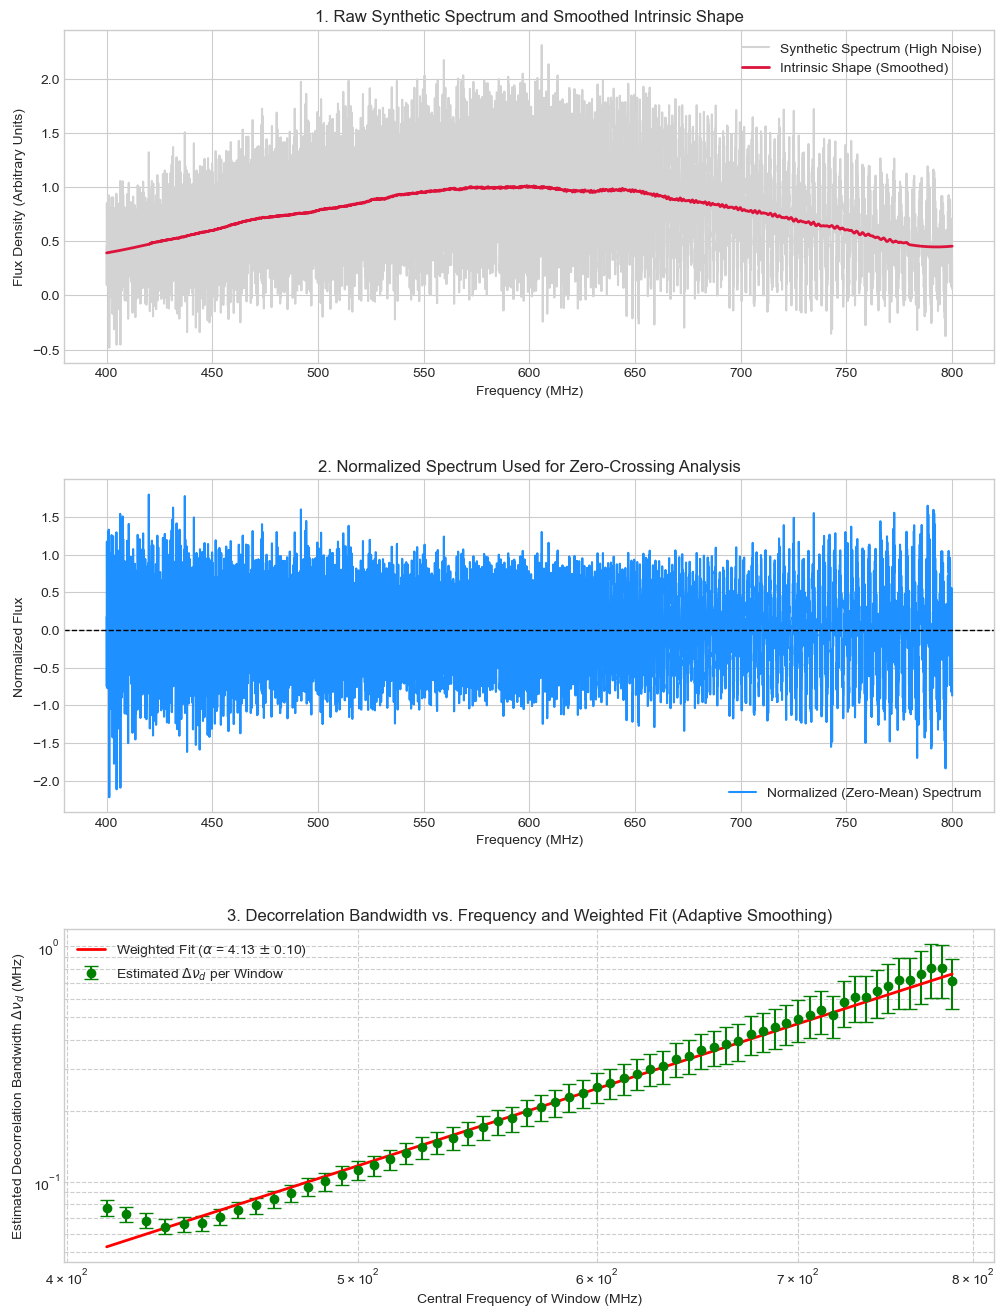

In [ ]:
# ==============================================================================
# Manual ACF Fitting Notebook
# ==============================================================================
# This notebook allows for manual, interactive fitting of sub-banded ACFs
# independent of the main automated pipeline.

# --- Cell 1: Imports ---
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- Imports for Interactive Controls ---
from ipywidgets import interact, IntSlider, FloatSlider, FloatRangeSlider, FloatText, Dropdown, VBox, HBox, Button, Output, Textarea, Label
from IPython.display import display

# --- Imports from your Scintillation Analysis Pipeline ---
# Ensure the scint_analysis package is in your Python path
try:
    from scint_analysis.analysis import (
        lorentzian_model_1_comp,
        lorentzian_model_2_comp,
        lorentzian_model_3_comp
    )
    from scint_analysis.core import ACF
except ImportError as e:
    print(f"Error: Could not import from scint_analysis package. Make sure it is installed or in the Python path. {e}")

# --- Cell 2: Load Pre-Calculated ACF Data ---
ACF_RESULTS_PATH = '/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/zach/zach_acf_results.pkl' #'/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/data/cache/zach/zach_acf_results.pkl' # # Adjust this path if necessary

#try:
with open(ACF_RESULTS_PATH, 'rb') as f:
    acf_results = pickle.load(f)
print(f"Successfully loaded ACF results from '{ACF_RESULTS_PATH}'")
num_subbands = len(acf_results['subband_acfs'])
print(f"Found data for {num_subbands} sub-bands.")
#except FileNotFoundError:
#    print(f"ERROR: ACF results file not found at '{ACF_RESULTS_PATH}'.")
#    print("Please run the main pipeline with 'save_intermediate_steps: true' and 'halt_after_acf: true' to generate it.")
#    acf_results = None

# --- Cell 3: Model Configuration Hub ---
# This dictionary maps model names to their functions and parameter details.
MODEL_CONFIG = {
    '1-Component Lorentzian': {
        'func': lorentzian_model_1_comp,
        'param_names': ['gamma1', 'm1', 'c1'],
        'bounds': ([-np.inf, 0, -np.inf], [np.inf, np.inf, np.inf])
    },
    '2-Component Lorentzian': {
        'func': lorentzian_model_2_comp,
        'param_names': ['gamma1', 'm1', 'gamma2', 'm2', 'c2'],
        'bounds': ([-np.inf, 0, -np.inf, 0, -np.inf], [np.inf, np.inf, np.inf, np.inf, np.inf])
    },
    '3-Component Lorentzian': {
        'func': lorentzian_model_3_comp,
        'param_names': ['gamma1', 'm1', 'gamma2', 'm2', 'gamma3', 'm3', 'c3'],
        'bounds': ([-np.inf, 0, -np.inf, 0, -np.inf, 0, -np.inf], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
    }
}


# --- Cell 4: Main Interactive Fitting Function ---
if acf_results:
    # --- Create Widgets ---
    subband_slider = IntSlider(min=0, max=num_subbands-1, step=1, value=0, description='Sub-band Index:')
    model_selector = Dropdown(options=MODEL_CONFIG.keys(), value='2-Component Lorentzian', description='Model:')
    
    max_lag_overall = max(np.max(np.abs(lags)) for lags in acf_results['subband_lags_mhz'])
    
    # NEW: Create text boxes for manual entry of the fit range
    fit_range_min_text = FloatText(value=-max_lag_overall, description='Min Lag:')
    fit_range_max_text = FloatText(value=max_lag_overall, description='Max Lag:')
    
    fit_range_slider = FloatRangeSlider(
        value=[-max_lag_overall, max_lag_overall],
        min=-max_lag_overall,
        max=max_lag_overall,
        step=0.1,
        description='Fit Lag Range (MHz):',
        continuous_update=False, # Only update when mouse is released
        style={'description_width': 'initial'}
    )

    fit_button = Button(description="Perform Fit", button_style='success', icon='cogs')
    print_fits_button = Button(description="Print All Fit Results", button_style='info', icon='print')
    param_sliders_container = VBox([])
    plot_output = Output()
    results_output_area = Textarea(layout={'width': '98%', 'height': '200px'})

    # --- In-memory storage for the fit results ---
    all_fits_storage = {}

    def create_param_sliders(model_name):
        config = MODEL_CONFIG[model_name]
        param_names = config['param_names']
        sliders = [FloatSlider(min=0, max=20, step=0.01, value=0.5, description=p) for p in param_names]
        param_sliders_container.children = tuple(sliders)
        for s in sliders:
            s.observe(on_visuals_change, names='value')

    def draw_plot(subband_idx, model_name, fit_range, initial_guesses, popt=None):
        with plot_output:
            plot_output.clear_output(wait=True)
            config = MODEL_CONFIG[model_name]
            model_func = config['func']
            
            center_freq = acf_results['subband_center_freqs_mhz'][subband_idx]
            lags = acf_results['subband_lags_mhz'][subband_idx]
            acf_data = acf_results['subband_acfs'][subband_idx]
            acf_err = acf_results.get('subband_acfs_err', [None]*num_subbands)[subband_idx]
            
            # MODIFIED: Combine masks
            zero_lag_mask = (lags != 0)
            range_mask = (lags >= fit_range[0]) & (lags <= fit_range[1])
            final_fit_mask = zero_lag_mask & range_mask
            
            x_data, y_data, sigma = lags[final_fit_mask], acf_data[final_fit_mask], acf_err[final_fit_mask] if acf_err is not None else None

            fig, ax = plt.subplots(figsize=(10, 6))
            # Plot all data points, but highlight the fit region
            ax.errorbar(lags, acf_data, yerr=acf_err, fmt='.', color='lightgray', label='All Data', capsize=3, alpha=1., zorder=1)
            ax.plot(x_data, y_data, 'o', color='purple', alpha=0.2, label='Data in Fit Range')
            
            # NEW: Add a shaded region to show the fitting range
            ax.axvspan(fit_range[0], fit_range[1], color='gray', alpha=0.15, zorder=0)

            y_guess = model_func(x_data, *initial_guesses)
            ax.plot(x_data, y_guess, 'r--', label='Initial Guess', zorder=5)

            if popt is not None:
                y_fit = model_func(x_data, *popt)
                ax.plot(x_data, y_fit, 'k-', label='Final Fit', lw=2, zorder=10)

            ax.set_title(f"Assisted Fit for Sub-band {subband_idx} @ {center_freq:.2f} MHz ({model_name})")
            ax.set_xlabel("Frequency Lag (MHz)")
            ax.set_ylabel("Correlation")
            ax.set_ylim(-0.05, 0.1)
            ax.set_xlim(-10, 10)
            ax.grid(True, linestyle=':')
            ax.legend()
            plt.show()

    def on_visuals_change(change):
        subband_idx = subband_slider.value
        model_name = model_selector.value
        fit_range = fit_range_slider.value
        initial_guesses = [s.value for s in param_sliders_container.children]
        draw_plot(subband_idx, model_name, fit_range, initial_guesses)

    def on_fit_button_clicked(b):
        subband_idx = subband_slider.value
        model_name = model_selector.value
        fit_range = fit_range_slider.value
        initial_guesses = [s.value for s in param_sliders_container.children]
        config = MODEL_CONFIG[model_name]
        model_func, bounds = config['func'], config['bounds']
        
        lags = acf_results['subband_lags_mhz'][subband_idx]
        acf_data = acf_results['subband_acfs'][subband_idx]
        acf_err = acf_results.get('subband_acfs_err', [None]*num_subbands)[subband_idx]
        
        zero_lag_mask = (lags != 0)
        range_mask = (lags >= fit_range[0]) & (lags <= fit_range[1])
        final_fit_mask = zero_lag_mask & range_mask
        
        x_data, y_data, sigma = lags[final_fit_mask], acf_data[final_fit_mask], acf_err[final_fit_mask] if acf_err is not None else None
        
        popt, pcov = None, None
        try:
            popt, pcov = curve_fit(model_func, x_data, y_data, p0=initial_guesses, sigma=sigma, bounds=bounds, maxfev=5000)
            all_fits_storage[subband_idx] = {'popt': popt, 'pcov': pcov, 'model_name': model_name}
        except RuntimeError:
            print("Fit failed to converge. Try different initial guesses.")
        except ValueError as e:
            print(f"Fit failed due to a value error: {e}")
        
        draw_plot(subband_idx, model_name, fit_range, initial_guesses, popt=popt)

    def on_print_fits_clicked(b):
        output_str = ""
        sorted_indices = sorted(all_fits_storage.keys())
        for idx in sorted_indices:
            fit_info = all_fits_storage[idx]
            model_name = fit_info['model_name']
            popt = fit_info['popt']
            pcov = fit_info['pcov']
            
            perr = np.sqrt(np.diag(pcov))
            center_freq = acf_results['subband_center_freqs_mhz'][idx]
            param_names = MODEL_CONFIG[model_name]['param_names']
            
            output_str += f"--- Sub-band {idx} @ {center_freq:.2f} MHz (Model: {model_name}) ---\n"
            for name, val, err in zip(param_names, popt, perr):
                output_str += f"  {name}: {val:.4f} +/- {err:.4f}\n"
            output_str += "\n"
        
        results_output_area.value = output_str

    def on_model_change(change):
        create_param_sliders(change['new'])
        on_visuals_change(None)
        
    def link_text_to_slider(change):
        # Update slider when text box value changes, preventing inversion
        min_val = fit_range_min_text.value
        max_val = fit_range_max_text.value
        if min_val < max_val:
            fit_range_slider.value = (min_val, max_val)

    def link_slider_to_text(change):
        # Update text boxes when slider value changes
        fit_range_min_text.value = round(change.new[0], 2)
        fit_range_max_text.value = round(change.new[1], 2)
        # Also trigger a visual update
        on_visuals_change(None)

    # --- Link Widgets to Functions ---
    subband_slider.observe(on_visuals_change, names='value')
    model_selector.observe(on_model_change, names='value')
    fit_button.on_click(on_fit_button_clicked)
    print_fits_button.on_click(on_print_fits_clicked)

    # Link the new text and slider widgets
    fit_range_slider.observe(link_slider_to_text, names='value')
    fit_range_min_text.observe(link_text_to_slider, names='value')
    fit_range_max_text.observe(link_text_to_slider, names='value')
    
    # --- Display Dashboard ---
    create_param_sliders(model_selector.value)
    
    # MODIFIED: Create a new layout for the fit range controls
    fit_range_controls = VBox([
        Label(value="Fit Lag Range (MHz):"),
        HBox([fit_range_min_text, fit_range_max_text]),
        fit_range_slider
    ])

    dashboard = VBox([
        HBox([subband_slider, model_selector]),
        fit_range_controls, # Add the new control group
        param_sliders_container,
        HBox([fit_button, print_fits_button]),
        plot_output,
        results_output_area
    ])
    display(dashboard)
    
    on_visuals_change(None)

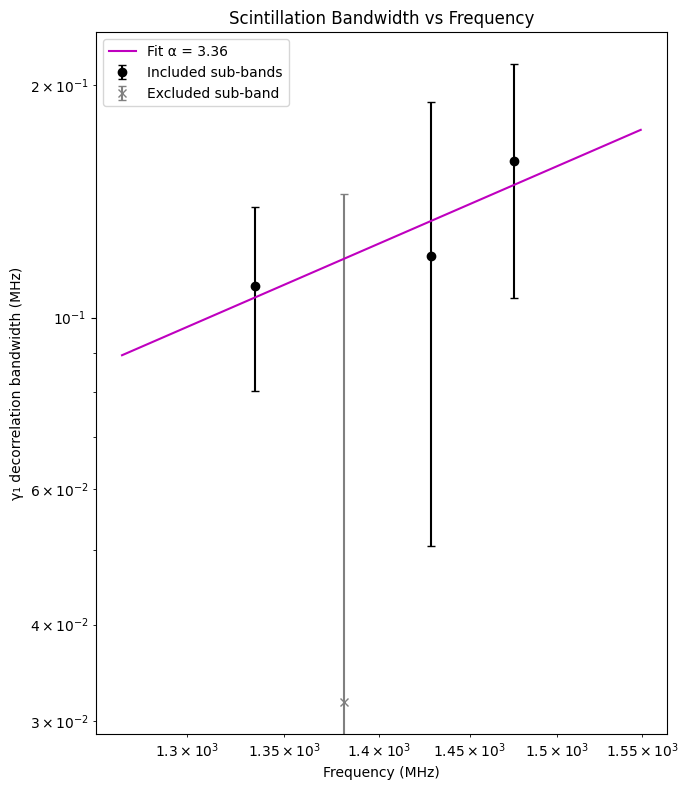

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# γ1 decorrelation bandwidths
freq = np.array([1334.68, 1381.56, 1428.44, 1475.32])  # MHz
gamma = np.array([0.1098, 0.0317, 0.1203, 0.1595])      # MHz
sigma = np.array([0.0294, 0.1130, 0.0698, 0.0536])      # MHz uncertainties

# Mark the band with very low S/N that we exclude from the primary fit
mask = np.array([True, False, True, True])              # exclude sub‑band 1 (1381 MHz)

# Do a log–log linear fit on the retained points
log_nu = np.log10(freq[mask])
log_gamma = np.log10(gamma[mask])
coeffs = np.polyfit(log_nu, log_gamma, 1)
alpha = coeffs[0]
intercept = coeffs[1]

# Plot
fig, ax = plt.subplots(figsize=(7,8))
ax.errorbar(freq[mask], gamma[mask], yerr=sigma[mask],
            fmt='o', capsize=3, label='Included sub‑bands', c='k')
ax.errorbar(freq[~mask], gamma[~mask], yerr=sigma[~mask],
            fmt='x', capsize=3, label='Excluded sub‑band', c='gray')

# Best‑fit power‑law line
nu_fit = np.linspace(freq.min()*0.95, freq.max()*1.05, 200)
gamma_fit = 10**(intercept + alpha*np.log10(nu_fit))
ax.plot(nu_fit, gamma_fit, '-', label=f'Fit α = {alpha:.2f}', c='m')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('γ₁ decorrelation bandwidth (MHz)')
ax.set_title('Scintillation Bandwidth vs Frequency')
ax.legend()
plt.tight_layout()



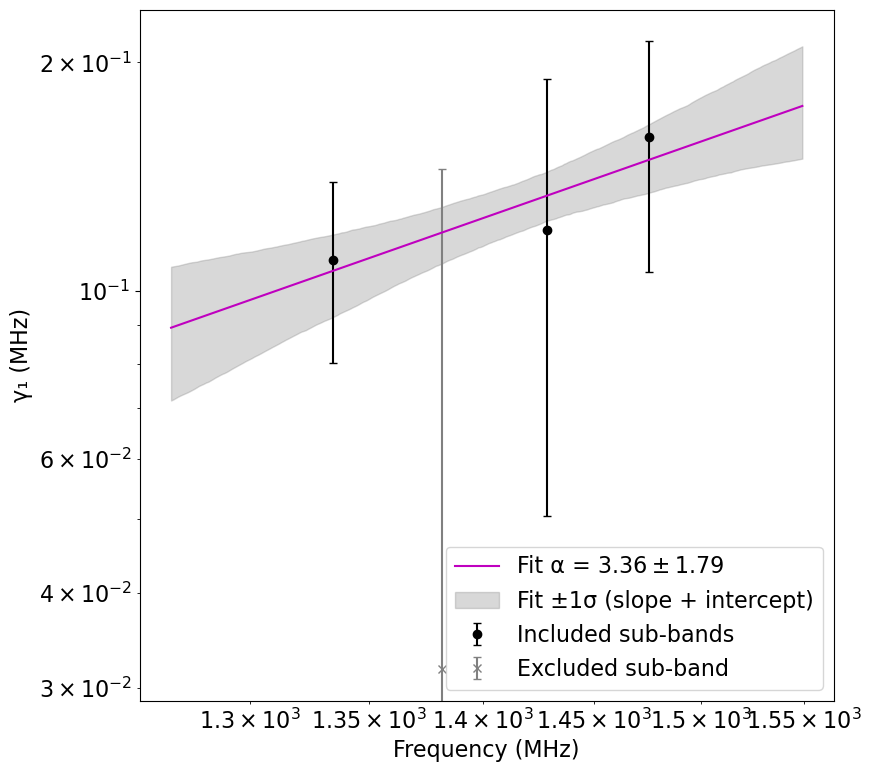

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# Data
freq = np.array([1334.68, 1381.56, 1428.44, 1475.32])  # MHz
gamma = np.array([0.1098, 0.0317, 0.1203, 0.1595])      # MHz
sigma = np.array([0.0294, 0.1130, 0.0698, 0.0536])      # MHz uncertainties
mask = np.array([True, False, True, True])              # exclude sub‑band 1

# Log–log fit with covariance matrix
log_nu = np.log10(freq[mask])
log_gamma = np.log10(gamma[mask])
(coeffs, cov) = np.polyfit(log_nu, log_gamma, 1, cov=True)
alpha, intercept = coeffs
alpha_err = np.sqrt(cov[0, 0])
intercept_err = np.sqrt(cov[1, 1])
cov_ai = cov[0, 1]

# Frequencies for plotting fit and ±1 σ envelope
nu_fit = np.linspace(freq.min()*0.95, freq.max()*1.05, 300)
log_nu_fit = np.log10(nu_fit)

# Monte‑Carlo draws to illustrate joint envelope
rng = np.random.default_rng(seed=42)
samples = rng.multivariate_normal(coeffs, cov, size=1000)
log_gamma_draws = samples[:, 0][:, None] * log_nu_fit + samples[:, 1][:, None]
gamma_draws = 10**log_gamma_draws
lower = np.percentile(gamma_draws, 16, axis=0)
upper = np.percentile(gamma_draws, 84, axis=0)
median = 10**(alpha*log_nu_fit + intercept)

fig, ax = plt.subplots(figsize=(9,8))
# Data points
ax.errorbar(freq[mask], gamma[mask], yerr=sigma[mask], fmt='o', capsize=3, c='k',
            label='Included sub‑bands')
ax.errorbar(freq[~mask], gamma[~mask], yerr=sigma[~mask], fmt='x', capsize=3, c='gray',
            label='Excluded sub‑band')

# Best‑fit line
ax.plot(nu_fit, median, '-', label=f'Fit α = {alpha:.2f} ± {alpha_err:.2f}', c='m')

# 1σ region
ax.fill_between(nu_fit, lower, upper, color='grey', alpha=0.3,
                label='Fit ±1σ (slope + intercept)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('γ₁ (MHz)')
#ax.set_title('Scintillation Bandwidth vs Frequency with Slope Uncertainty')
ax.legend()
plt.tight_layout()


(2.287775973609587,
 0.40030757023706376,
 3.6328238413851226,
 0.6168408522176745,
 2.510364135561717,
 0.3362389343523798)

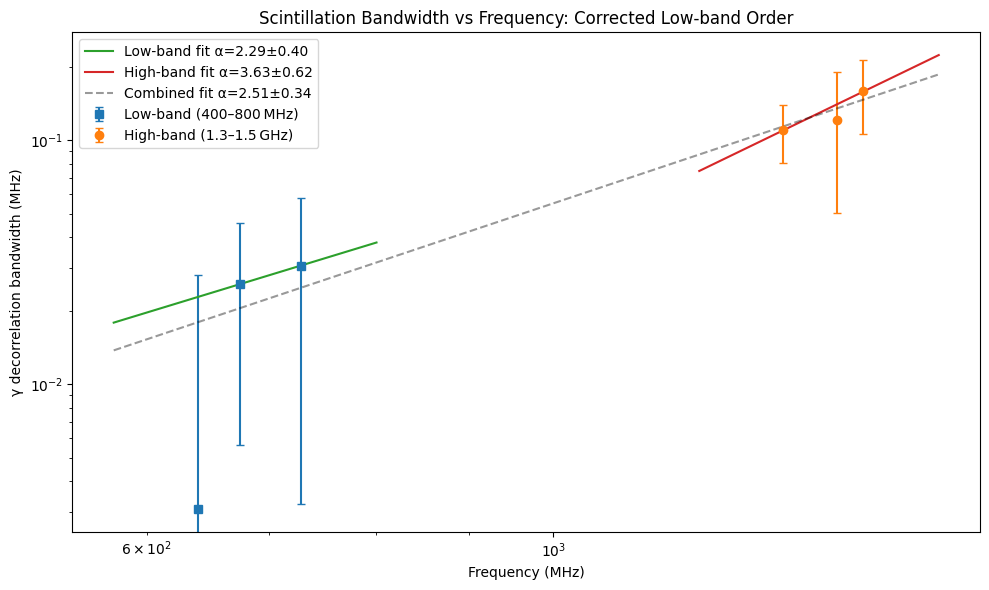

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# High‑band (unchanged)
freq_high = np.array([1334.68, 1428.44, 1475.32])
gamma_high = np.array([0.1098, 0.1203, 0.1595])
sigma_high = np.array([0.0294, 0.0698, 0.0536])

# Corrected low‑band: reverse the original order
freq_low = np.array([639.5791602472219, 674.4990322254934,
                     693.3742262989571, 727.977477196368])
gamma_low = np.array([0.00307364980666266, 0.025709408346127994,
                      0.08895984789247124, 0.030597509878495525])
sigma_low = np.array([0.024944904778742453, 0.02005131275943251,
                      np.nan, 0.027363149797342057])

# Drop NaN error point
valid = ~np.isnan(sigma_low)
freq_low, gamma_low, sigma_low = freq_low[valid], gamma_low[valid], sigma_low[valid]

def loglog_fit(nu, g, gerr):
    log_nu = np.log10(nu)
    log_g = np.log10(g)
    sigma_log = gerr / (g * np.log(10))
    w = 1 / sigma_log**2
    coeffs, cov = np.polyfit(log_nu, log_g, 1, w=w, cov=True)
    slope, intercept = coeffs
    slope_err = np.sqrt(cov[0, 0])
    return slope, slope_err, intercept

alpha_low, err_low, a_low = loglog_fit(freq_low, gamma_low, sigma_low)
alpha_high, err_high, a_high = loglog_fit(freq_high, gamma_high, sigma_high)

freq_all = np.hstack([freq_low, freq_high])
gamma_all = np.hstack([gamma_low, gamma_high])
sigma_all = np.hstack([sigma_low, sigma_high])
alpha_all, err_all, a_all = loglog_fit(freq_all, gamma_all, sigma_all)

# Plot
fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(freq_low, gamma_low, yerr=sigma_low, fmt='s', capsize=3, label='Low‑band (400–800 MHz)')
ax.errorbar(freq_high, gamma_high, yerr=sigma_high, fmt='o', capsize=3, label='High‑band (1.3–1.5 GHz)')

nu_low = np.linspace(freq_low.min()*0.9, freq_low.max()*1.1, 200)
nu_high = np.linspace(freq_high.min()*0.9, freq_high.max()*1.1, 200)
nu_all = np.linspace(freq_all.min()*0.9, freq_all.max()*1.1, 400)

ax.plot(nu_low, 10**(a_low + alpha_low*np.log10(nu_low)), '-', label=f'Low‑band fit α={alpha_low:.2f}±{err_low:.2f}')
ax.plot(nu_high, 10**(a_high + alpha_high*np.log10(nu_high)), '-', label=f'High‑band fit α={alpha_high:.2f}±{err_high:.2f}')
ax.plot(nu_all, 10**(a_all + alpha_all*np.log10(nu_all)), 'k--', alpha=0.4, label=f'Combined fit α={alpha_all:.2f}±{err_all:.2f}')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('γ decorrelation bandwidth (MHz)')
ax.set_title('Scintillation Bandwidth vs Frequency: Corrected Low‑band Order')
ax.legend()
plt.tight_layout()

(alpha_low, err_low, alpha_high, err_high, alpha_all, err_all)


(np.float64(2.287775973609587),
 np.float64(0.40030757023706376),
 np.float64(3.632823841385127),
 np.float64(0.616840852217674),
 np.float64(2.5103641355617174),
 np.float64(0.3362389343523798))

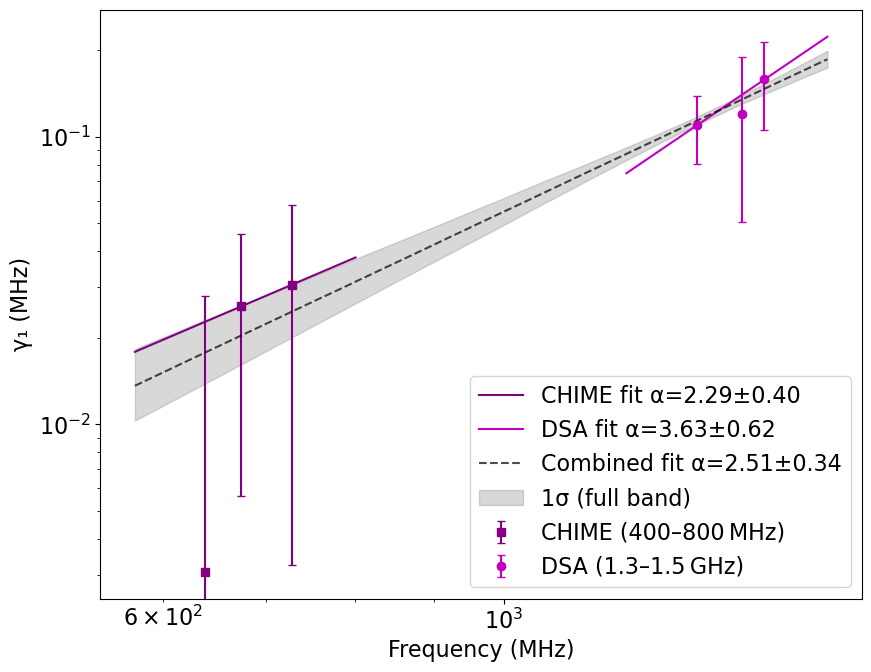

In [105]:
import numpy as np
import matplotlib.pyplot as plt

# --- Data as given ---
freq_high = np.array([1334.68, 1428.44, 1475.32])
gamma_high = np.array([0.1098, 0.1203, 0.1595])
sigma_high = np.array([0.0294, 0.0698, 0.0536])

freq_low = np.array([639.5791602472219, 674.4990322254934,
                     693.3742262989571, 727.977477196368])
gamma_low = np.array([0.00307364980666266, 0.025709408346127994,
                      0.08895984789247124, 0.030597509878495525])
sigma_low = np.array([0.024944904778742453, 0.02005131275943251,
                      np.nan, 0.027363149797342057])

# Drop NaN
mask = ~np.isnan(sigma_low)
freq_low, gamma_low, sigma_low = freq_low[mask], gamma_low[mask], sigma_low[mask]

# Helper to fit log–log weighted
def wls_loglog(nu, g, gerr):
    log_nu = np.log10(nu)
    log_g = np.log10(g)
    sigma_log_g = gerr / (g * np.log(10))
    weights = 1 / sigma_log_g**2
    coeffs, cov = np.polyfit(log_nu, log_g, 1, w=weights, cov=True)
    slope, intercept = coeffs
    return slope, intercept, cov

alpha_low, a_low, cov_low = wls_loglog(freq_low, gamma_low, sigma_low)
alpha_high, a_high, cov_high = wls_loglog(freq_high, gamma_high, sigma_high)

freq_all = np.hstack([freq_low, freq_high])
gamma_all = np.hstack([gamma_low, gamma_high])
sigma_all = np.hstack([sigma_low, sigma_high])
alpha_all, a_all, cov_all = wls_loglog(freq_all, gamma_all, sigma_all)

alpha_low_err = np.sqrt(cov_low[0,0])
alpha_high_err = np.sqrt(cov_high[0,0])
alpha_all_err = np.sqrt(cov_all[0,0])

# --- Build uncertainty band for combined fit ---
nu_fit = np.linspace(freq_all.min()*0.9, freq_all.max()*1.1, 500)
log_nu_fit = np.log10(nu_fit)

# Draw samples of slope+intercept from covariance
rng = np.random.default_rng(12345)
samples = rng.multivariate_normal([alpha_all, a_all], cov_all, size=2000)
log_gamma_draws = samples[:,0][:,None]*log_nu_fit + samples[:,1][:,None]
gamma_draws = 10**log_gamma_draws
median = np.median(gamma_draws, axis=0)
lower = np.percentile(gamma_draws, 16, axis=0)
upper = np.percentile(gamma_draws, 84, axis=0)

# --- Plot ---
fig, ax = plt.subplots(figsize=(9,7))

# Data
ax.errorbar(freq_low, gamma_low, yerr=sigma_low, fmt='s', capsize=3, c='purple',
            label='CHIME (400–800 MHz)')
ax.errorbar(freq_high, gamma_high, yerr=sigma_high, fmt='o', capsize=3, c='m',
            label='DSA (1.3–1.5 GHz)')

# Low-band and high-band fit lines
nu_low = np.linspace(freq_low.min()*0.9, freq_low.max()*1.1, 200)
nu_high = np.linspace(freq_high.min()*0.9, freq_high.max()*1.1, 200)
ax.plot(nu_low, 10**(a_low + alpha_low*np.log10(nu_low)), c='purple',
        label=f'CHIME fit α={alpha_low:.2f}±{alpha_low_err:.2f}')
ax.plot(nu_high, 10**(a_high + alpha_high*np.log10(nu_high)), c='m',
        label=f'DSA fit α={alpha_high:.2f}±{alpha_high_err:.2f}')

# Combined fit line and 1σ shaded region
ax.plot(nu_fit, median, 'k--', alpha=0.7,
        label=f'Combined fit α={alpha_all:.2f}±{alpha_all_err:.2f}')
ax.fill_between(nu_fit, lower, upper, color='grey', alpha=0.3,
                label='1σ (full band)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('γ₁ (MHz)')#
#ax.set_title('zach')
ax.legend()
plt.tight_layout()

(alpha_low, alpha_low_err,
 alpha_high, alpha_high_err,
 alpha_all, alpha_all_err)


(8.502456613544723,
 10.88467240614406,
 6.80042821556026,
 2.1350276586999284,
 6.662237742869245,
 0.7209613493320396)

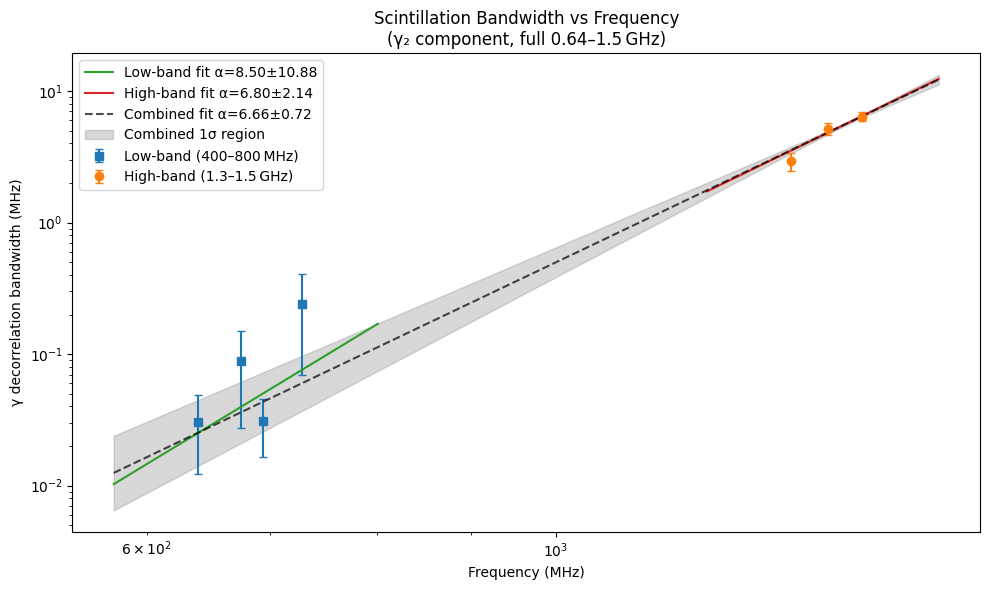

In [82]:
import numpy as np
import matplotlib.pyplot as plt

freq_high = np.array([1342.49, 1405.00, 1467.51])
gamma_high = np.array([2.9251, 5.1510, 6.3992])
sigma_high = np.array([0.4747, 0.5412, 0.5077])

#freq_high = np.array([1475.32, 1428.44, 1381.56, 1334.68])
#gamma_high = np.array([9.4793, 2.098, 1.06, 4.08])
#sigma_high = np.array([0.4386, 0.2805, 0.2829, 0.4377])

# Low‑band values
freq_low = np.array([727.977477196368, 693.3742262989571,
                     674.4990322254934, 639.5791602472219])
gamma_low = np.array([0.239177755414001, 0.03098038269728807,
                      0.08902349045914636, 0.03060903481854996])
sigma_low = np.array([0.16924869256962413, 0.014594476244811576,
                      0.06139504876062839, 0.01827234228783935])

# ==== Weighted log–log fit helper ====
def wls_loglog(nu, g, gerr):
    log_nu = np.log10(nu)
    log_g = np.log10(g)
    sigma_log_g = gerr / (g * np.log(10))
    w = 1 / sigma_log_g**2
    coeffs, cov = np.polyfit(log_nu, log_g, 1, w=w, cov=True)
    slope, intercept = coeffs
    slope_err = np.sqrt(cov[0, 0])
    return slope, intercept, slope_err, cov

# Band‑limited fits
alpha_high, a_high, err_high, cov_high = wls_loglog(freq_high, gamma_high, sigma_high)
alpha_low,  a_low,  err_low,  cov_low  = wls_loglog(freq_low,  gamma_low,  sigma_low)

# Combined fit
freq_all   = np.hstack([freq_low,  freq_high])
gamma_all  = np.hstack([gamma_low, gamma_high])
sigma_all  = np.hstack([sigma_low, sigma_high])
alpha_all, a_all, err_all, cov_all = wls_loglog(freq_all, gamma_all, sigma_all)

# === Uncertainty band for combined fit ===
nu_grid = np.linspace(freq_all.min()*0.9, freq_all.max()*1.1, 600)
log_nu_grid = np.log10(nu_grid)

# Monte‑Carlo draws from slope/intercept covariance
rng = np.random.default_rng(20240627)
samples = rng.multivariate_normal([alpha_all, a_all], cov_all, size=3000)
log_gamma_draws = samples[:, 0][:, None] * log_nu_grid + samples[:, 1][:, None]
gamma_draws = 10**log_gamma_draws

median = np.median(gamma_draws, axis=0)
lower  = np.percentile(gamma_draws, 16, axis=0)
upper  = np.percentile(gamma_draws, 84, axis=0)

# === Plot ===
fig, ax = plt.subplots(figsize=(10, 6))

# Data points
ax.errorbar(freq_low,  gamma_low,  yerr=sigma_low,  fmt='s', capsize=3,
            label='Low‑band (400–800 MHz)')
ax.errorbar(freq_high, gamma_high, yerr=sigma_high, fmt='o', capsize=3,
            label='High‑band (1.3–1.5 GHz)')

# Fit lines
nu_low  = np.linspace(freq_low.min()*0.9,  freq_low.max()*1.1, 200)
nu_high = np.linspace(freq_high.min()*0.9, freq_high.max()*1.1, 200)

ax.plot(nu_low,  10**(a_low  + alpha_low *np.log10(nu_low)),
        '-', label=f'Low‑band fit α={alpha_low:.2f}±{err_low:.2f}')
ax.plot(nu_high, 10**(a_high + alpha_high*np.log10(nu_high)),
        '-', label=f'High‑band fit α={alpha_high:.2f}±{err_high:.2f}')

# Combined fit with shaded 1σ region
ax.plot(nu_grid, median, 'k--', alpha=0.7,
        label=f'Combined fit α={alpha_all:.2f}±{err_all:.2f}')
ax.fill_between(nu_grid, lower, upper, color='grey', alpha=0.3,
                label='Combined 1σ region')

# Axes & cosmetics
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('γ decorrelation bandwidth (MHz)')
ax.set_title('Scintillation Bandwidth vs Frequency\n(γ₂ component, full 0.64–1.5 GHz)')
ax.legend()
plt.tight_layout()

(alpha_low, err_low, alpha_high, err_high, alpha_all, err_all)


In [75]:
import numpy as np
import matplotlib.pyplot as plt
from math import log10

# High‑band subset (2 points)
#freq_high = np.array([1475.32, 1334.68])
#gamma_high = np.array([9.4793, 4.08])
#sigma_high = np.array([0.4386, 0.4377])
freq_high = np.array([1475.32, 1428.44, 1381.56, 1334.68])
gamma_high = np.array([9.4793, 2.098, 1.06, 4.08])
sigma_high = np.array([0.4386, 0.2805, 0.2829, 0.4377])

# Low‑band data
freq_low = np.array([727.977477196368, 693.3742262989571,
                     674.4990322254934, 639.5791602472219])
gamma_low = np.array([0.239177755414001, 0.03098038269728807,
                      0.08902349045914636, 0.03060903481854996])
sigma_low = np.array([0.16924869256962413, 0.014594476244811576,
                      0.06139504876062839, 0.01827234228783935])

# Simple OLS for >=3 points
def ols_loglog(nu, g):
    log_nu = np.log10(nu)
    log_g = np.log10(g)
    coeffs, cov = np.polyfit(log_nu, log_g, 1, cov=True)
    slope, intercept = coeffs
    slope_err = np.sqrt(cov[0,0])
    return slope, intercept, slope_err, cov

# two‑point line (no covariance)
def two_point_loglog(nu, g):
    x1, x2 = np.log10(nu)
    y1, y2 = np.log10(g)
    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - slope * x1
    return slope, intercept

alpha_high, a_high = two_point_loglog(freq_high, gamma_high)
err_high = np.nan

alpha_low, a_low, err_low, cov_low = ols_loglog(freq_low, gamma_low)

# Combined fit using all 6 points (cov ok)
freq_all = np.hstack([freq_low, freq_high])
gamma_all = np.hstack([gamma_low, gamma_high])
alpha_all, a_all, err_all, cov_all = ols_loglog(freq_all, gamma_all)

# Uncertainty band from combined cov
nu_grid = np.linspace(freq_all.min()*0.9, freq_all.max()*1.1, 600)
log_nu_grid = np.log10(nu_grid)
rng = np.random.default_rng(321)
samples = rng.multivariate_normal([alpha_all, a_all], cov_all, size=3000)
log_gamma_draws = samples[:,0][:,None] * log_nu_grid + samples[:,1][:,None]
gamma_draws = 10**log_gamma_draws
median = np.median(gamma_draws, axis=0)
lower = np.percentile(gamma_draws, 16, axis=0)
upper = np.percentile(gamma_draws, 84, axis=0)

# Plot
fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(freq_low, gamma_low, yerr=sigma_low, fmt='s', capsize=3, c='m',
            label='Low‑band (400–800 MHz)')
ax.errorbar(freq_high, gamma_high, yerr=sigma_high, fmt='o', capsize=3,c='purple',
            label='High‑band subset (1.3–1.5 GHz)')

nu_low = np.linspace(freq_low.min()*0.9, freq_low.max()*1.1, 200)
nu_high = np.linspace(freq_high.min()*0.9, freq_high.max()*1.1, 200)
ax.plot(nu_low, 10**(a_low + alpha_low*np.log10(nu_low)),
        c='m', label=f'Low‑band fit α={alpha_low:.2f}±{err_low:.2f}')
ax.plot(nu_high, 10**(a_high + alpha_high*np.log10(nu_high)),
        c='purple', label=f'High‑band fit α={alpha_high:.2f} (2‑pt)')

ax.plot(nu_grid, median, 'k--', alpha=0.7,
        label=f'Combined fit α={alpha_all:.2f}±{err_all:.2f}')
ax.fill_between(nu_grid, lower, upper, color='grey', alpha=0.3,
                label='Combined 1σ region')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('γ₂ decorrelation bandwidth (MHz)')
ax.set_title('Scintillation Bandwidth vs Frequency\n(γ₂ component, high-band subset)')
ax.legend()
plt.tight_layout()

(alpha_low, err_low, alpha_high, alpha_all, err_all)


ValueError: too many values to unpack (expected 2)